# Importing Files

In [ ]:
len(COLUMNS_TO_GRAPH)

24

In [1]:
RIGHT_AVY_HEADER = 'Angular Velocity Y (rad/s).2'
LEFT_AVY_HEADER = 'Angular Velocity Y (rad/s).3'
COLUMNS_TO_GRAPH = ['Acceleration Y (m/s^2)',  'Angular Velocity Y (rad/s)',##right thigh
                    'Acceleration Y (m/s^2).1','Angular Velocity Y (rad/s).1',##left thigh
                    'Acceleration Y (m/s^2).2', RIGHT_AVY_HEADER,##right shank
                    'Acceleration Y (m/s^2).3',LEFT_AVY_HEADER ]##left shank
tmp = []
for val in COLUMNS_TO_GRAPH:
  tmp.append(val.replace('Y','X'))
  tmp.append(val.replace('Y','Z'))
COLUMNS_TO_GRAPH.extend(tmp)

COLUMNS_TO_AREA = {  'Acceleration Y (m/s^2)':'right thigh',  'Angular Velocity Y (rad/s)':'right thigh',##right thigh
                    'Acceleration Y (m/s^2).1':'left thigh','Angular Velocity Y (rad/s).1':'left thigh',##left thigh
                    'Acceleration Y (m/s^2).2':'right shank', RIGHT_AVY_HEADER:'right shank',##right shank
                    'Acceleration Y (m/s^2).3':'left shank',LEFT_AVY_HEADER:'left shank' }##left shank
tmp = list(COLUMNS_TO_AREA.items())
for val in tmp:
  COLUMNS_TO_AREA[val[0].replace('Y','X')] = val[1]
  COLUMNS_TO_AREA[val[0].replace('Y','Z')] = val[1]
COLUMNS_TO_LEG = {}
for k in list(COLUMNS_TO_AREA.keys()):
  COLUMNS_TO_LEG[k]=COLUMNS_TO_AREA[k].split(' ')[0]
COLUMNS_BY_SENSOR = [{'sensor':'thigh','right':'Acceleration Y (m/s^2)','left': 'Acceleration Y (m/s^2).1'},
                     {'sensor':'thigh','right':'Angular Velocity Y (rad/s)', 'left':'Angular Velocity Y (rad/s).1'},
                     {'sensor':'shank','right':'Acceleration Y (m/s^2).2','left':'Acceleration Y (m/s^2).3'},
                     {'sensor':'shank','right':RIGHT_AVY_HEADER, 'left':LEFT_AVY_HEADER},]
tmp = COLUMNS_BY_SENSOR.copy()
for d in tmp:
   COLUMNS_BY_SENSOR.append({'sensor':d['sensor'], 'right':d['right'].replace('Y','X'), 'left':d['left'].replace('Y','X')})
   COLUMNS_BY_SENSOR.append({'sensor':d['sensor'], 'right':d['right'].replace('Y','Z'), 'left':d['left'].replace('Y','Z')})

In [2]:
import os
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False
if IN_COLAB:
  print("We're running Colab")
if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/gdrive'
  print("Colab: mounting Google drive on ", mount)
  drive.mount(mount, force_remount=True)
  # Switch to the directory on the Google Drive that you want to use
  drive_root = mount + "/MyDrive/Adult/2022/Deep_Kahlon/Walking_Opal_Research/13_Data/TD_data/"
  #drive_root = mount + "/MyDrive/Walking_Opal_Research/13_Data/TD_data/"
  # Create drive_root if it doesn't exist
  create_drive_root = False
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)
  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive

Colab: Changing directory to  /content/gdrive/MyDrive/Adult/2022/Deep_Kahlon/Walking_Opal_Research/13_Data/TD_data/
/content/gdrive/.shortcut-targets-by-id/1P7-TiZy5FtPsC-TWb3r-avvL2uj8dZE5/Walking_Opal_Research/13_Data/TD_data


In [3]:
import os
import glob
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from collections import Counter
import random
from typing import List, Tuple
from scipy.spatial import distance
#from scipy.signal import resample
from scipy.signal import correlate, find_peaks, butter, sosfilt
from scipy.interpolate import interp1d
from scipy.stats import shapiro, ttest_rel, wilcoxon
! pip install statsmodels
import statsmodels.api as sm
from collections import defaultdict
import pickle

In [4]:
DATA_DIR = 'raw_data_2023.01.31'#'Text_File/Master_Data--TD_1-30_CSVFiles/Subjects_1-30-inw1_through_osw1'
GATE_CROSSING = -0.3
FREQUENCY = 128

In [5]:
PACE = 'normal'

In [ ]:
SAVE_DIR = os.path.join('Analysis','05_12_23')
if not os.path.exists(SAVE_DIR):
  os.mkdir(SAVE_DIR)
SAVE_DIR = os.path.join(SAVE_DIR,PACE)

In [6]:
gate_files = [os.path.basename(x) for x in glob.glob(os.path.join(DATA_DIR,"*.csv"))]

print(len(gate_files), "data files found")
print("first couple")
print(gate_files[:5])

268 data files found
first couple
['20220817-105702-subject_01inw1.csv', '20220824-111108-subject_04inw1.csv', '20220825-100815-subject_05inw1.csv', '20220817-110531-subject_01ifw1.csv', '20220824-112236-subject_04ifw2.csv']


In [7]:
def extract_trial_data(filename, verbose=False):
  end_part = filename.split('_')[1].replace('.csv','')
  subjectID_str = ''.join([x for x in end_part[:3] if x.isdigit()])
  subjectID =int(subjectID_str)
  end_part= end_part.replace(subjectID_str, '', 1)
  trial =int(''.join([x for x in end_part if x.isdigit()]))
  end_part= end_part.replace(str(trial), '')
  inout = 'outdoors' if ('o' in end_part) else 'indoors'
  pace = end_part[1]
  if pace=='s':
    pace = 'slow'
  elif pace =='f':
    pace ='fast'
  elif pace =='n':
    pace='normal'
  timestamp = datetime.datetime.strptime(filename.split('-')[0], '%Y%m%d')
  if verbose:
    print("filename:", filename)
    print("subjectID:", subjectID)
    print("indoor/outdoor:", inout)
    print("trial:", trial)
    print("pace:", pace)
    print("data collected on:", timestamp)
  return subjectID, inout, pace, trial, timestamp

In [8]:
def check_indoor_and_outdoor(metadata):
  '''removes subjects from the dataset if they don't have at least one indoor
  and one outdoor file'''
  remove_subjectID = []
  for _,subs in metadata.groupby(by=['subjectID']):
    if len(subs[subs.inout=='indoors'])==0 or len(subs[subs.inout=='outdoors'])==0:
      remove_subjectID.append(subs.subjectID.iloc[0])
      print("\n found incomplete data")
      print(subs[['filename', 'subjectID', 'inout', 'pace']])
  return metadata[~metadata.subjectID.isin(remove_subjectID)]


In [9]:
def load_metadata(PACE, DATA_DIR):
  ##load all data files
  gate_files = [os.path.basename(x) for x in glob.glob(os.path.join(DATA_DIR,"*.csv"))]
  metadata_list = []
  for file in gate_files:
    subjectID, inout, pace, trial, timestamp = extract_trial_data(file, verbose=False)
    metadata_list.append([file, subjectID, inout, pace, trial, timestamp])
  metadata = pd.DataFrame(metadata_list, columns=['filename', 'subjectID', 'inout', 'pace', 'trial', 'timestamp'])
  print("paces found in raw data", metadata['pace'].unique())
  ##filter on pace
  metadata = metadata.loc[metadata['pace']==PACE]
  ##checks and removes incomplete data
  metadata = check_indoor_and_outdoor(metadata)
  metadata.reset_index(inplace=True, drop=True)
  return metadata

In [16]:
metadata=load_metadata(PACE, DATA_DIR)
##filter out only the specified walking pace
metadata = metadata.loc[metadata['pace']==PACE]
metadata = check_indoor_and_outdoor(metadata)
metadata.reset_index(inplace=True, drop=True)
metadata

paces found in raw data ['normal' 'fast' 'slow']


<ipython-input-8-c4b09c4f7b28>:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _,subs in metadata.groupby(by=['subjectID']):
<ipython-input-8-c4b09c4f7b28>:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _,subs in metadata.groupby(by=['subjectID']):


,filename,subjectID,inout,pace,trial,timestamp
0,20220817-105702-subject_01inw1.csv,1,indoors,normal,1,2022-08-17
1,20220824-111108-subject_04inw1.csv,4,indoors,normal,1,2022-08-24
2,20220825-100815-subject_05inw1.csv,5,indoors,normal,1,2022-08-25
3,20220824-111447-subject_04inw2.csv,4,indoors,normal,2,2022-08-24
4,20220820-195205-subject_02inw1.csv,2,indoors,normal,1,2022-08-20
...,...,...,...,...,...,...
85,20221113-171429-subject_29inw2.csv,29,indoors,normal,2,2022-11-13
86,20221119-103754-subject_30onw1.csv,30,outdoors,normal,1,2022-11-19
87,20221119-100727-subject_30inw2.csv,30,indoors,normal,2,2022-11-19
88,20221119-100257-subject_30inw1.csv,30,indoors,normal,1,2022-11-19


## Preprocessing

In [10]:
def remove_ends_data(df_p,remove_seconds: float =5, verbose=False):
  '''warning, this changes the data in memory every time it is run
  do not run multiple times on the same data
  remove_seconds: seconds on begining and end to remove '''
  if verbose:
    print("shape before removing intro and tail ", df_p.shape)
  n_remove = remove_seconds*FREQUENCY
  df_p.drop(index=df_p.index[:n_remove], axis=0, inplace=True)
  # Using DataFrame.tail() function to drop first n rows
  df_p = df_p.tail(-n_remove)
  if verbose:
    print("shape after removing intro and tail ", df_p.shape)
  return df_p


In [11]:
def low_pass_butterworth(df_b, N: int=4, Wn: float = 20):
  '''pd.options.mode.chained_assignment = None'''
  sos=butter(N, Wn, btype='lowpass', analog=False, output='sos', fs=FREQUENCY)
  dict_df = {}
  for col in df_b.columns:
    if col in COLUMNS_TO_GRAPH:
      filtered = sosfilt(sos, df_b[col].to_numpy().copy())
      dict_df[col] = filtered
    else:
      dict_df[col] = df_b[col].to_numpy()
  return pd.DataFrame(dict_df)
  #for col in COLUMNS_TO_GRAPH:
    #filtered = sosfilt(sos, df_b[col].to_numpy().copy())
    #for i, ind in enumerate(df_b.index):
      #df_b.loc[ind, col]=filtered[i]
      #df_b[col].iloc[i]=filtered[i]
    #df_b.loc[:, col]=filtered
    #df_b[col]=filtered
    #df_b[col]=pd.Series(filtered, name=col)
    #df_b = df_b.assign(col=sosfilt(sos, df_b[col]))
  #return df_b

## Load Data

def apply_rolling_window(df_p, rolling_window=3, verbose=False):
  '''warning, this changes the data in memory every time it is run
  do not run multiple times on the same data
  Noise causes the values to jump around zero making the exact real zero
  crossing hard to define a moving avg filter is applied'''
  for column in COLUMNS_TO_GRAPH:
    df_p[column] = df_p[column].rolling(rolling_window).mean()
  df_p.drop(index=df_p.index[:rolling_window-1], axis=0, inplace=True)
  df_p.reset_index(inplace=True)
  if verbose:
    print("shape after rolling window ", df_p.shape)

In [12]:
def load_data(filename:str, low_pass: bool = True, N: int=4, Wn:float=20):
  '''takes in only the filename, not the path'''
  df_a = pd.read_csv(os.path.join(DATA_DIR, filename), usecols=COLUMNS_TO_GRAPH)
  df_in = remove_ends_data(df_a)
  if low_pass:
    return low_pass_butterworth(df_in, N=N, Wn=Wn)
  else:
     return df_in

In [13]:
def select_random_df(metadata,data_lookup ):
  subjectID_list = metadata['subjectID'].unique()
  subjectID = subjectID_list[random.randint(0,len(subjectID_list)-1)]
  filenames = metadata[metadata.subjectID==subjectID]['filename'].to_numpy()
  filename = filenames[np.random.randint(low=0, high=(len(filenames)-1))]
  return data_lookup[filename]  , filename

The details of the chosen file are displayed below

In [17]:
start = datetime.datetime.now()
data_lookup = {}
for filename in metadata['filename']:
  data_lookup[filename]=load_data(filename)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

took 73.901736 to run


In [18]:
file =metadata['filename'].iloc[random.randint(0,metadata.shape[0]-1)]
df = data_lookup[file]
extract_trial_data(file, verbose=True)
print("number data points per data stream", df.shape[0])

filename: 20220820-195525-subject_02inw2.csv
subjectID: 2
indoor/outdoor: indoors
trial: 2
pace: normal
data collected on: 2022-08-20 00:00:00
number data points per data stream 21760


In [ ]:
##print_metadata
with open(os.path.join(DATA_DIR, file), 'r') as fileobj:
  ct = 0
  for line in fileobj.readlines():
    ct +=1
    print(line.split(',')[0])
    if ct ==14:
      break

Metadata
File Format Version=6
Monitor Case IDs= :SI-001572:SI-001562:SI-001559:SI-001573
Monitor Labels= :R Thigh:L Thigh:R Shank 1510 R:L Shank 1801
Version String1=APDM Inc.
Version String2=2016-10-04-3cdef2ce2a3717c4e8eddcd0e0bd391ede8550fd
Version String3=2019-05-29 18:10:14 monitor_hv11_bv2_20161006_3cdef2ce.hex
Calibration Version=6
Sample Rate=128
Decimation Factor=10
Time Good=0
Decimation Bypass=0
Gravity=9.806000
Magnetic field magnitude=53.200000


## Low Pass Filter

In [ ]:
def generate_examples_of_butter_filter(zero_crossing_lookup, metadata,  N:int = 4, Wn:float = 20, column:str = LEFT_AVY_HEADER):
  ##grab a random file and a random gate
  for i in range(20):
    random_int = random.randint(0,metadata.shape[0]-1)
    file = metadata['filename'].iloc[random_int]
    subjectID = metadata['subjectID'].iloc[random_int]
    df_filtered = load_data(file, low_pass = True, N=N, Wn=Wn)
    df = load_data(file, low_pass = False)
    zero_crossings = zero_crossing_lookup[file]['right']
    gate_ind = random.randint(0,len(zero_crossings)-2)
    center = zero_crossings[gate_ind][0]
    points = df[column].to_numpy()[center-1*FREQUENCY:center+1*FREQUENCY]
    points_filtered = df_filtered[column].to_numpy()[center-1*FREQUENCY:center+1*FREQUENCY]
    t = np.array([x for x in range(len(points))])/FREQUENCY
    fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8))
    ax1.plot(t, points)
    ax1.set_title('Raw signal 2s')
    ax1.grid(visible=True)
    ax2.plot(t, points_filtered)
    ax2.set_title(" Butterworth Filter " +" N = "+str(N)+", Wn = "+str(Wn)+"Hz")
    #ax2.set_title(" center " + str(center)+" N="+str(N)+", Wn="+str(Wn))
    ax2.grid(visible=True)
    print()
    _=fig.suptitle("Subject " +str(subjectID)+" " + column+ " " + COLUMNS_TO_AREA[column])
    filter_dir = os.path.join(SAVE_DIR, "butterworth_examples")
    if not os.path.exists(filter_dir):
      os.mkdir(filter_dir)
    image_name = file.replace(".csv", '')+ " center " +str(center)+'.png'
    fig.savefig(os.path.join(filter_dir, image_name) )

### Messing with Butterworth filter - skip section

In [ ]:
generate_examples_of_butter_filter(zero_crossing_lookup, metadata)

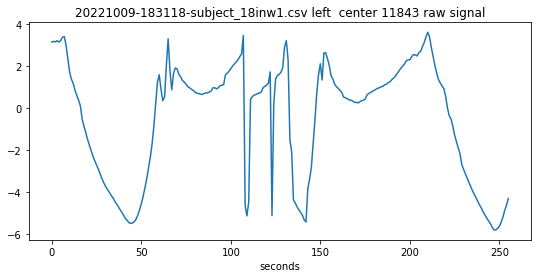

In [ ]:
#file = '20221009-172428-subject_17inw2.csv'
#center = 1376
#file ="20220823-134741-subject_03inw2.csv"
#center = 1061
file = "20221009-183118-subject_18inw1.csv"
center = 11843
df = load_data(file, low_pass=False)
points = df[LEFT_AVY_HEADER].to_numpy()[center-1*FREQUENCY:center+1*FREQUENCY]
plt.plot(points)
plt.title(file+" "+"left "+" center " + str(center)+" raw signal" )
plt.xlabel("seconds")
fig = plt.gcf()
fig.set_size_inches(9,4)

In [ ]:
t = np.array([x for x in range(len(points))])/FREQUENCY
fig, (ax1,ax15, ax2, ax3) = plt.subplots(4, 1, sharex=True, figsize=(12,16))
ax1.plot(t, points)
ax1.set_title('Raw signal 2s')
ax1.grid(visible=True)
ax15
sos05 = butter(4, 15, 'lowpass', fs=FREQUENCY,analog=False, output='sos')
filtered05 = sosfilt(sos05, points)
ax15.plot(t, filtered05)
ax15.set_title('After 15 Hz low-pass filter')
ax15.set_xlabel('Time [seconds]')
ax15.grid(visible=True)
sos = butter(4, 20, 'lowpass', fs=FREQUENCY,analog=False, output='sos')
filtered = sosfilt(sos, points)
ax2.plot(t, filtered)
ax2.set_title('After 20 Hz low-pass filter')
ax2.set_xlabel('Time [seconds]')
ax2.grid(visible=True)

sos2 = butter(4, 25, 'lowpass',analog=False, fs=FREQUENCY, output='sos')
filtered2 = sosfilt(sos2, points)
ax3.plot(t, filtered2)
ax3.set_title('After 25 Hz low-pass filter')
ax3.set_xlabel('Time [seconds]')
ax3.grid(visible=True)
plt.tight_layout()
plt.show()

In [ ]:
N = 4
Wn = 20
df = load_data(file, low_pass = True, N=N, Wn=Wn)
points = df[LEFT_AVY_HEADER].to_numpy()[center-1*FREQUENCY:center+1*FREQUENCY]
t = np.array([x for x in range(len(points))])/FREQUENCY
plt.plot( t, points)
plt.title(file+" "+"left "+" center " + str(center)+" N="+str(N)+", Wn="+str(Wn) )
plt.xlabel("seconds")
fig = plt.gcf()
fig.set_size_inches(9,4)

# Graph Raw Data

graph the middle of the angular velocity z data stream for each file

In [ ]:
SAVE_DIR

'Analysis/06_20_23/normal'

In [ ]:
angularz = ['Angular Velocity Z (rad/s).2', 'Angular Velocity Z (rad/s).3']
save_dir = os.path.join(SAVE_DIR, "Angular Velocity Z (rad-s)")
if not os.path.exists(SAVE_DIR):
  os.mkdir(SAVE_DIR)
if not os.path.exists(save_dir):
  os.mkdir(save_dir)
window = 300
for ind in range(metadata.shape[0]):
  filename =metadata['filename'].iloc[ind]
  subjectID = metadata['subjectID'].iloc[ind]
  inout = metadata['inout'].iloc[ind]
  df_a = pd.read_csv(os.path.join(DATA_DIR, filename), usecols=COLUMNS_TO_GRAPH)
  fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(7.5,5))
  for sensor in angularz:
    area = COLUMNS_TO_AREA[sensor]
    middle_i = df_a.shape[0]//2
    data = df_a[sensor][middle_i-window:middle_i+window]
    ax.plot(data, label=area)
    ax.legend()
  leg_part = area.replace("left",'').replace("right",'')
  title = angularz[0].replace(".2","").replace(os.path.sep, "-") +"_"+leg_part.replace(" ", '')+ "_"+str(subjectID)+"_"+inout
  ax.set_title(title +"_ind:"+str(middle_i))
  fig.suptitle(filename)
  fig.savefig(os.path.join(save_dir, title))


# Detect Gate Crossings

In [ ]:
def find_swing_stance_index(signal, min_percent=35):
  '''finds the peak right before the valley of the angular velocity y
  data stream.
  input: signal from a single gate
  returns: index and value'''
  min_index = int(min_percent*len(signal)/100)
  max_index, valley_value = find_lowest_valley(signal)
  peak_indices = find_peaks(signal)[0]
  possible_stance_change_index = []
  edge_start = 3
  edge_end = len(signal)-edge_start -1
  for x in peak_indices:
    if (edge_end > x > edge_start) and (max_index > x > min_index):
      possible_stance_change_index.append(x)
  peak_values = [signal[x] for x in possible_stance_change_index]
  if len(peak_values)==0:
    #plt.plot(signal)
    #pname = "signal_np.pickle"
    #with open(pname, 'wb') as fileobj:
    #  pickle.dump(np.array(signal),fileobj )
    raise ValueError("couldn't find peak.min index {} max index {} peak indices ".format(min_index,max_index)+str(peak_indices))

  stance_change_index =  possible_stance_change_index[peak_values.index(max(peak_values))]
  stance_change_value = signal[stance_change_index]
  return stance_change_index, stance_change_value

In [ ]:
def find_lowest_valley(signal):
  '''finds the min peak in a signal.
  returns the x,y values from that signal where the min peak is'''
  assert (type(signal)==list or type(signal)==np.ndarray)
  inv_signal = -1*signal
  peak_indices = find_peaks(inv_signal)[0]
  edge_start = 1
  edge_end = len(signal)-edge_start -1
  peak_indices = [x for x in peak_indices if (edge_start < x < edge_end)]
  peak_values = [signal[x] for x in peak_indices]
  min_index =peak_values.index(min(peak_values))
  return peak_indices[min_index],peak_values[min_index]

def max_peak(signal, edge_start = 3):
  '''finds the max peak in a signal.
  returns the x,y values from that signal where the max peak is'''
  peak_indices = find_peaks(signal)[0]
  edge_end = len(signal)-edge_start -1
  peak_indices = [x for x in peak_indices if (edge_start < x < edge_end)]
  peak_values = [signal[x] for x in peak_indices]
  max_index =peak_values.index(max(peak_values))
  return peak_indices[max_index],peak_values[max_index]

##  Context

In the graphs below, I have plotted the gate crossings as detected. A cycle is defined as the data between two gate crossings. A gate crossing is defined not by crossing the gate crossing global value. gate crossigns are highlighted with a red marker in the 3 cycle graphs. Index in this data is not equal to that in the excel file because the 5s that were removed. The outdoor data is significantly messier than the indoor.


In [ ]:
def extract_gate_crossings(df: pd.core.frame.DataFrame, header:str, gate_crossing: float = -0.6) -> List[int]:
  '''input
  gate_crossing: set the zero crossing below zero to avoid false positives
  returns: zero_crossings: a list of all the indices when a value in df crosses from below gate_crossing to above it
  '''
  zero_crossings = []
  for i, x in enumerate(df[header].to_list()):
    if i < df.shape[0]-1:
      #before = df[header].iloc[i]
      #after = df[header].iloc[i+1]
      ##zero crossing detected
      if df[header].iloc[i-2:i].mean() < gate_crossing and df[header].iloc[i:i+2].mean() > gate_crossing:
        zero_crossings.append(i)
  return zero_crossings


In [ ]:
def pair_gate_ends(zero_crossings: List[int], sensor: str = None, filename: str=None, gate_length_bounds: dict =None ) -> List[Tuple[int]]:
  if gate_length_bounds:
    min_gate_length = gate_length_bounds[filename][sensor][0]
    max_gate_length = gate_length_bounds[filename][sensor][1]
  zero_pairs = []
  save= True
  for i in range(len(zero_crossings)-1):
    if not gate_length_bounds:
      save = True
    else:
      gate_length = zero_crossings[i+1]- zero_crossings[i]
      if min_gate_length < gate_length < max_gate_length:
        save = True
      else:
        save = False
    if save:
      zero_pairs.append((zero_crossings[i], zero_crossings[i+1]))
  return zero_pairs

In [ ]:
def check_shape_zero_crossings(zero_gd, dstream):
  '''checks that there is a valley at all, and that there exists a
  peak to the left of the valley and the right of ~30% of the gate data points'''
  passed_zeros = []
  for zero_pair in zero_gd:
    gate_d =   dstream[zero_pair[0]:zero_pair[1]]
    try:
      find_swing_stance_index(gate_d)
      v_i, v_v = find_lowest_valley(gate_d)
      assert v_i > int(0.5*len(gate_d)), "stance valley index must be greatest and on the right"
    except ValueError:
      pass
    except AssertionError:
      pass
    else:
      passed_zeros.append(zero_pair)
  return passed_zeros

In [ ]:
def calc_all_gate_crossings(metadata, data_lookup: dict, gate_crossing: float = GATE_CROSSING, gate_length_bounds: dict =None):
  '''detects gate crossings for each leg for every file.
  creates a lookup dict that allows for looking up gate values given a filename and leg
  saves zero crossings as tuples, not as a list, this way the tuples can be
  filtered based on min,max gate lengths
  '''
  zero_crossing_lookup = {}
  for filename in metadata['filename'].to_list():
    df_1 = data_lookup[filename]
    ##zero crossings are lists here
    zero_crossings_right = extract_gate_crossings(df_1,RIGHT_AVY_HEADER, gate_crossing= gate_crossing)
    zero_crossings_left = extract_gate_crossings(df_1,LEFT_AVY_HEADER, gate_crossing= gate_crossing)
    ##conver zero crossings to tuples
    zero_crossings_right = pair_gate_ends(zero_crossings_right, sensor = RIGHT_AVY_HEADER,filename = filename, gate_length_bounds=gate_length_bounds)
    zero_crossings_left = pair_gate_ends(zero_crossings_left, sensor =LEFT_AVY_HEADER, filename = filename, gate_length_bounds=gate_length_bounds)
    ##check that the gates have the right shape
    zero_crossings_right = check_shape_zero_crossings(zero_crossings_right, df_1[RIGHT_AVY_HEADER].to_numpy())
    zero_crossings_left = check_shape_zero_crossings(zero_crossings_left, df_1[LEFT_AVY_HEADER].to_numpy())

    zero_crossing_lookup[filename]={'right':zero_crossings_right, 'left':zero_crossings_left}
  return zero_crossing_lookup


In [ ]:
start = datetime.datetime.now()
##doesn't save anything
zero_crossing_lookup=calc_all_gate_crossings(metadata, data_lookup)
print("took", (datetime.datetime.now()-start), "to run")

took 0:00:00.000173 to run


In [ ]:
def graph_zero_crossings(zero_crossings: List[Tuple[int]], avy_data,filename:str, save_dir: str = 'gate_crossings', window: int = 50, graph_limit: int = 20, gate_max: int = None):
  '''graph_limit : number of graphs to make
  gate_max: if set, sets a max gate size. this allows you to create graphs of only small gates to look for sources of errors
  returns: None. saves and displays graphs
  '''
  max_gates_display = 3
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  assert(len(zero_crossings)>max_gates_display),"not enough zero crossings to plot"
  for i in range(3,len(zero_crossings)):
    if len(zero_crossings)>4:
      start = zero_crossings[i][0]
      end = zero_crossings[i][1]
      if (not gate_max) or ((end-start )< gate_max):
        fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(25,7))
        zero_cross_indices = [avy_data.index[zero_crossings[i][0]], avy_data.index[zero_crossings[i][1]]]
        zero_cross_values = [avy_data.iloc[zero_crossings[i][0]],avy_data.iloc[zero_crossings[i][1]] ]
        ax[0].plot(avy_data.iloc[end-window:end+window])
        ax[0].set_title(label='around recent zero')
        ax[0].scatter([zero_cross_indices[1]],[zero_cross_values[1]]  , color='red')
        ax[1].plot(avy_data.iloc[start:end])
        ax[1].set_title(label='prev 1 cycle')
        ax[1].scatter(zero_cross_indices,zero_cross_values  , color='red')
        ax[2].plot(avy_data.iloc[zero_crossings[i-max_gates_display][1]:end])
        ax[2].scatter(zero_cross_indices,zero_cross_values  , color='red')
        ax[2].set_title(label='prev 3 cycles')
        ax[2].scatter(zero_cross_indices,zero_cross_values  , color='red')
        fig.suptitle("graph " + "{:,}".format(graph_limit) + ". "+filename+" inspecting row "+"{:,}".format(end) + ". gate size "+str(end-start))
        fig.savefig(os.path.join(save_dir,str(graph_limit)+'.png'))
        graph_limit -=1
        if graph_limit==0:
          break

In [ ]:

graph_zero_crossings(zero_crossing_lookup[file][COLUMNS_TO_LEG[RIGHT_AVY_HEADER]],
                     df[RIGHT_AVY_HEADER],filename=file,
                     save_dir= os.path.join(SAVE_DIR,'gate_crossings'),
                     window= 50, graph_limit = 10)

# Analyze the size of the average gate



In [ ]:
def avg_std_gate_lengths(zero_crossings: List[Tuple[int]]):
  points_p_gate = [x[1]-x[0] for x in zero_crossings]
  points_p_gate = np.array(points_p_gate)
  return  points_p_gate.mean() , points_p_gate.std(), points_p_gate.max(), points_p_gate.min()

In [ ]:
def hist_gate_lengths(zero_crossing: List[Tuple[int]]):
  avg, std , m, n = avg_std_gate_lengths(zero_crossing)
  print("mean:", round(avg,2), "std:",round(std,2), " max:", m, "min:", n )
  points_p_gate = [x[1]-x[0] for x in zero_crossing]
  plt.hist(points_p_gate)
  _ = plt.title("Histogram of Gate Size")
  plt.xlabel("size of gate (data points)")
  plt.ylabel("# of gates detected")

## Basic Stats of Gate Lengths

calc avg, std, max, min of sensors, with and then with a gate crossing at -0.6 and then at 0

Take notice in the table below that the max and min gate sizes are quite a bit larger than the avg. This being true, they are rare outliers as the low std shows.

In [ ]:
save_dir_gate_lengths = os.path.join(SAVE_DIR, "stats_of_gate_lengths")
if not os.path.exists(save_dir_gate_lengths):
  os.mkdir(save_dir_gate_lengths)

In [ ]:
def find_gate_crossing_threshold(data_lookup, metadata: pd.core.frame.DataFrame, save_dir_gate_lengths:str):
  '''to find out how the gate crossing threshold impacts the stats of the gate
     lengths, calculate the average gate lengths with varying gate_crossing values'''
  stats_data = []
  for gate_crossing in [0,-0.3, -0.6, -0.9, -1.2]:
    zero_crossing_lookup=calc_all_gate_crossings(metadata, data_lookup, gate_crossing = gate_crossing)
    for sensor_cols in [RIGHT_AVY_HEADER, LEFT_AVY_HEADER]:
      for i, inout in enumerate(['indoors', 'outdoors']):
        all_gate_lengths = []
        for x in metadata[metadata['inout']==inout].groupby(by=['subjectID', 'pace']):
          df_trials=x[1]
          for filename in df_trials['filename'].to_numpy():
            zero_crossings = zero_crossing_lookup[filename][COLUMNS_TO_LEG[sensor_cols]]
            points_p_gate = [x[1]-x[0] for x in zero_crossings]
            all_gate_lengths.extend(points_p_gate)
        all_gate_lengths = np.array(all_gate_lengths)
        stats_data.append([sensor_cols, COLUMNS_TO_AREA[sensor_cols], inout, all_gate_lengths.mean(), all_gate_lengths.std(), all_gate_lengths.max(), all_gate_lengths.min(), gate_crossing])
  stats_df = pd.DataFrame(stats_data, columns=['sensor_name', 'area', 'inout', 'avg gate length (data points)', 'std', 'max', 'min', 'vertical_gate_crossing'])
  stats_df.to_csv(os.path.join(save_dir_gate_lengths, "gate_lengths_per_vertical_crossing.csv"))
  return stats_df

In [ ]:
def graphing_gate_crossing_thresholds(stats_df: pd.core.frame.DataFrame, save_dir_gate_lengths: str):
  for column_to_graph in [RIGHT_AVY_HEADER, LEFT_AVY_HEADER]:
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
    for i, inout in enumerate(['indoors', 'outdoors']):
      wherec = ((stats_df['inout']==inout) & (stats_df['sensor_name']==column_to_graph))
      avg = stats_df[wherec]['avg gate length (data points)']
      std =  stats_df[wherec]['std']
      mx =  stats_df[wherec]['max']
      x_gates =stats_df[wherec]['vertical_gate_crossing']
      #fig, ax = plt.subplots()
      ax[i].plot(x_gates ,avg, color='black')
      ax[i].fill_between(x_gates, avg-std, avg+std, alpha=0.4, color='gray')
      ax[i].set_xlabel("gate crossing threshold")
      ax[i].set_ylabel("gate size (data points)")
      title = column_to_graph+ ' '+COLUMNS_TO_AREA[column_to_graph]
      _= ax[i].set_title( title+ ' ' + inout)
      fig.savefig(os.path.join(save_dir_gate_lengths,title.replace(os.path.sep, '-').replace('/', '-')+'.png'))

In [ ]:
start = datetime.datetime.now()
##saves data
stats_df= find_gate_crossing_threshold(data_lookup, metadata, save_dir_gate_lengths)
time_passed = (datetime.datetime.now()-start)
print("took",time_passed, "s to run")

In [ ]:
start = datetime.datetime.now()
graphing_gate_crossing_thresholds(stats_df, save_dir_gate_lengths)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")


In [ ]:
zero_crossing_lookup =calc_all_gate_crossings(metadata, data_lookup, GATE_CROSSING)


## Stats of Gate Lengths by File

In [ ]:
def stats_gate_lengths_by_file(metadata,data_lookup,  df_cols: List[str], save_dir_gate_lengths: str, fname_gate_length_file: str = "per_file", MAX_STD: float = 2, zero_crossing_lookup: dict =None):
  '''for each of the two main sensors, create a csv with the gate length
    stats for each file, also track the thresholds for each file of what
    defines an outlier'''
  filter_to_gate_thresh = {}
  for filename in metadata['filename']:
    filter_to_gate_thresh[filename] = {}
  print("gate crossing used", GATE_CROSSING)
  if not zero_crossing_lookup:
    zero_crossing_lookup=calc_all_gate_crossings(metadata, gate_crossing = GATE_CROSSING)
  for sensor_cols in [RIGHT_AVY_HEADER, LEFT_AVY_HEADER]:
    df_per_file = pd.DataFrame([], columns =df_cols )
    per_filename =fname_gate_length_file+'_'+ sensor_cols.replace(os.path.sep, '-').replace('/', '-')+".csv"
    for i, inout in enumerate(['indoors', 'outdoors']):
      for x in metadata[metadata['inout']==inout].groupby(by=['subjectID', 'pace']):
        df_trials=x[1]
        for filename in df_trials['filename'].values:
          subjectID, inout, pace, trial, timestamp =extract_trial_data(filename)
          zero_crossings = zero_crossing_lookup[filename][COLUMNS_TO_LEG[sensor_cols]]
          avg, std , ppgmax, ppgmin = avg_std_gate_lengths(zero_crossings)
          row = [sensor_cols,COLUMNS_TO_AREA[sensor_cols], inout, filename, trial, subjectID, avg,std,ppgmax, ppgmin,data_lookup[filename].shape[0], GATE_CROSSING]
          filter_to_gate_thresh[filename][sensor_cols] = (avg-MAX_STD*std, avg+MAX_STD*std)
          df_per_file = pd.concat([df_per_file, pd.DataFrame([row], columns=df_cols)])
    df_per_file.sort_values('std',inplace=True, ignore_index=True )
    df_per_file.to_csv(os.path.join(save_dir_gate_lengths,per_filename), index=False)
  print("saving file", fname_gate_length_file, " with gate length stats per file")
  return df_per_file, filter_to_gate_thresh

In [ ]:
def plot_gate_lengths_p_subject(filename,save_dir_gate_lengths):
  df_gate_lengths = pd.read_csv(os.path.join(save_dir_gate_lengths,filename))
  print("stats of gate lengths (data Points)")
  print(df_gate_lengths['avg gate length (data points)'].describe())
  print("\nstd of gate lengths (data Points)")
  print(df_gate_lengths['std'].describe())
  df_gate_lengths['std/avg'] =df_gate_lengths.apply(lambda x: x['std']/x['avg gate length (data points)'], axis=1)
  print("\nstats of std/avg")
  percentiles = df_gate_lengths['std/avg'].describe()
  print(percentiles)
  fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
  ax[0].scatter(df_gate_lengths['subjectID'].values,df_gate_lengths['std/avg'].values )
  _ = ax[0].set_xlabel("SubjectID")
  _ = ax[0].set_ylabel("std/avg")
  _ = ax[0].set_title("Variation in gate lengths per subject: "+df_gate_lengths['area'].iloc[0]+ " "+df_gate_lengths['sensor'].iloc[0])
  outliers_df = df_gate_lengths[df_gate_lengths['std/avg']>percentiles['75%']].copy()
  print("number of outliers defined by 75 percentile:", outliers_df.shape[0])
  print("outliers by indoors/outdoors")
  ct_indoors = outliers_df[outliers_df['in-out']=='indoors'].shape[0]
  print("\tindoors", ct_indoors, "{}%".format(round(100*ct_indoors/outliers_df.shape[0]),2))
  print("\toutdoors", outliers_df.shape[0]-ct_indoors, "{}%".format(round(100*(outliers_df.shape[0]-ct_indoors)/outliers_df.shape[0]),2))
  outlier_p_subject = Counter(outliers_df['subjectID'].values)
  osub = list(outlier_p_subject.keys())
  oct = [outlier_p_subject[x] for x in osub]
  ax[1].bar(osub,oct )
  _ = ax[1].set_xlabel("SubjectID")
  _ = ax[1].set_ylabel("count outlier files")
  _ = ax[1].set_title("75 Percentile outliers")
  fig.savefig(os.path.join(save_dir_gate_lengths,"std-avg_outlier_graph_"+df_gate_lengths['area'].iloc[0]+".png"))
  return df_gate_lengths

In [ ]:
start = datetime.datetime.now()
df_gate_stats_cols = ['sensor','area', 'in-out', 'filename','trial', 'subjectID' ,'avg gate length (data points)', 'std', 'max', 'min', 'data points per file', 'vertical_gate_crossing' ]
##saves data
df_per_file, filter_to_gate_thresh = stats_gate_lengths_by_file(metadata,data_lookup, df_gate_stats_cols, save_dir_gate_lengths, MAX_STD= 2, zero_crossing_lookup=zero_crossing_lookup)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

In [ ]:
##saves_data
df_gate_lengths_r = plot_gate_lengths_p_subject("per_file_Angular Velocity Y (rad-s).2.csv",save_dir_gate_lengths)

In [ ]:
df_gate_lengths_l = plot_gate_lengths_p_subject("per_file_Angular Velocity Y (rad-s).3.csv",save_dir_gate_lengths)

In [ ]:
df_gate_lengths_l[df_gate_lengths_l['std/avg']>0.2]


In [ ]:
df_gate_lengths_r[df_gate_lengths_r['std/avg']>0.2]

## Filter Outliers

filter out gates that are more than 2 std away from avg

In [ ]:
start = datetime.datetime.now()

##re-calculate the zero crossings with filter applied
zero_crossing_lookup=calc_all_gate_crossings(metadata, data_lookup, gate_crossing = GATE_CROSSING, gate_length_bounds= filter_to_gate_thresh)
##re-calculate the stats of the gate lengths now that the filter has been applied
df_gate_stats_cols = ['sensor','area', 'in-out', 'filename','trial', 'subjectID' ,'avg gate length (data points)', 'std', 'max', 'min', 'data points per file', 'vertical_gate_crossing' ]
df_per_file_filtered, _ = stats_gate_lengths_by_file(metadata,data_lookup, df_gate_stats_cols, save_dir_gate_lengths,
                                                     fname_gate_length_file = "per_file_2std_filtered_outliers" , MAX_STD= 2, zero_crossing_lookup=zero_crossing_lookup)
print("took", (datetime.datetime.now()-start), "to run")


In [ ]:
for filename in metadata.filename.values:
  for dire in ['left', 'right']:
    ct = 0
    crosses = zero_crossing_lookup[filename][dire]
    for tup in crosses:
      ct+=1
    print(filename, dire, ct)

## Summarize Data Removed/Missing

find the files that should be there, but are missing

In [ ]:
def find_missing(condition, name):
  one_to_thirty = set([x for x in range(1,31)])
  subjects_found = set(metadata[condition]['subjectID'].unique())
  subjects_missing = one_to_thirty.difference(subjects_found)
  print(PACE)
  print(name)
  print("subjects missing", subjects_missing)

In [ ]:
find_missing((metadata['inout']=='indoors') & (metadata['trial']==1), 'indoors trial 1')
find_missing((metadata['inout']=='indoors') & (metadata['trial']==2), 'indoors trial 2')
find_missing(metadata['inout']=='outdoors', 'outdoors')

normal
indoors trial 1
subjects missing {4}
normal
indoors trial 2
subjects missing {4}
normal
outdoors
subjects missing {4}


find the amount of data that was thrown out

first by the first 5s removal, then by the filtering

In [ ]:
print("5 s removed at beggining and end")
print('data points removed begining plus end of each file', 2*5*FREQUENCY)

5 s removed at beggining and end
data points removed begining plus end of each file 1280


butterworth filter is applied to the data

gate cycles are detected with an avg and std

limits are set based on 2std away from the avg. all gate time lengths that fall outside this range are removed. a shape profile is further used to filter the results and only save gates with a detectable valley and a detectable peak between (35% temporal data poin, index of valley)

In [ ]:
def count_data_points_saved(metadata):
  columns = ['filename', 'subjectID', 'inout', 'pace', 'trial', 'sensor', 'raw_data_points', 'good_data_points', 'percent_good']
  data = []
  for i, row in metadata.iterrows():
    filename = row.filename
    df_raw = load_data(filename)
    raw_data_points = df_raw.shape[0]
    for sensor in [LEFT_AVY_HEADER, RIGHT_AVY_HEADER]:
      new_row = {}
      #print("sensor", sensor)
      #t=data_lookup[filename][sensor]
      #t=t.dropna()
      #raw_data_points = len(t)
      zero_crossings=zero_crossing_lookup[filename][COLUMNS_TO_LEG[sensor]]
      gates = [tup[1]-tup[0] for tup in zero_crossings]
      data_points_saved = sum(gates)
      if raw_data_points<data_points_saved:
        print(zero_crossings)
        print(data_points_saved)
        print(raw_data_points)
        print("max", max(gates))
        return
      new_row['raw_data_points'] = raw_data_points
      new_row['good_data_points'] = data_points_saved
      new_row['percent_good']=round(data_points_saved*100/raw_data_points,2)
      new_row['sensor']=sensor
      new_row['filename']=filename
      new_row['subjectID']= row['subjectID']
      new_row['inout']=row['inout']
      new_row['pace']=row['pace']
      new_row['trial']=row['trial']
      data.append(new_row)
  df_good_data_ct = pd.DataFrame(data)
  return df_good_data_ct

In [ ]:
good_points_df = count_data_points_saved(metadata)

[(140, 315), (316, 489), (490, 657), (658, 836), (998, 1163), (1164, 1330), (1331, 1503), (1504, 1681), (1682, 1857), (1858, 2031), (2032, 2202), (2203, 2374), (2375, 2541), (2704, 2874), (2875, 3038), (3039, 3215), (3216, 3384), (3385, 3557), (3558, 3725), (3726, 3893), (3894, 4066), (4067, 4239), (4240, 4415), (4416, 4588), (4589, 4752), (4753, 4918), (4919, 5084), (5085, 5253), (5254, 5425), (5426, 5593), (5594, 5765), (5766, 5940), (5941, 6122), (6123, 6301), (6302, 6475), (6476, 6657), (6658, 6831), (6832, 6997), (6998, 7172), (7173, 7343), (7344, 7520), (7521, 7691), (7692, 7866), (7867, 8046), (8233, 8410), (8411, 8584), (8585, 8750), (8751, 8929), (8930, 9104), (9289, 9470), (9656, 9826), (9827, 9992), (9993, 10160), (10161, 10334), (10335, 10507), (10508, 10681), (10682, 10854), (10855, 11021), (11022, 11198), (11199, 11378), (11563, 11735), (11736, 11908), (11909, 12083), (12084, 12261), (12262, 12432), (12433, 12608), (12609, 12780), (12964, 13134), (13135, 13307), (13308, 1

In [ ]:
2*30*3

180

below we 'describe' the amount of good data. the count variable is the number of rows. The number is high because the data is split out for different sensors.

In [ ]:
print(PACE)
in_out = 'indoors'
print(in_out)
good_points_df[good_points_df['inout']==in_out]['percent_good'].describe()

normal
indoors


count    116.000000
mean     117.399138
std       40.628849
min       74.740000
25%       94.010000
50%       95.545000
75%      109.190000
max      194.770000
Name: percent_good, dtype: float64

In [ ]:
print(PACE)
in_out = 'outdoors'
print(in_out)
good_points_df[good_points_df['inout']==in_out]['percent_good'].describe()

normal
outdoors


count    58.000000
mean     92.681379
std       5.825674
min      61.130000
25%      92.687500
50%      94.010000
75%      95.607500
max      98.390000
Name: percent_good, dtype: float64

In [ ]:
def describe_sensors():
  sensors = list(good_points_df['sensor'].unique())
  for sensor in sensors:
    sub_df = good_points_df[good_points_df['sensor']==sensor]
    print(sensor)
    print("avg", round(sub_df['percent_good'].mean(),2))
    print("std", round(sub_df['percent_good'].std(),2))
    print("max", sub_df['percent_good'].max())
    print("min", sub_df['percent_good'].min())
print("indoors and outdoors")
describe_sensors()

indoors and outdoors
Angular Velocity Y (rad/s).3
avg 123.74
std 45.49
max 194.77
min 61.13
Angular Velocity Y (rad/s).2
avg 94.58
std 2.15
max 98.39
min 83.1


In [ ]:
LEFT_AVY_HEADER

'Angular Velocity Y (rad/s).3'

In [ ]:
pace = 'fast'
before_fname_left = 'per_file_Angular Velocity Y (rad-s).3.csv'
before_fname_right = 'per_file_Angular Velocity Y (rad-s).2.csv'
after_fname_right = 'per_file_2std_filtered_outliers_Angular Velocity Y (rad-s).2.csv'
after_fname_left = 'per_file_2std_filtered_outliers_Angular Velocity Y (rad-s).3.csv'
full_path = os.path.join("./Analysis/05_13_23/",pace, "stats_of_gate_lengths",before_fname_left )
df1 = pd.read_csv(full_path)

In [ ]:
df1

,sensor,area,in-out,filename,trial,subjectID,avg gate length (data points),std,max,min,data points per file,vertical_gate_crossing
0,Angular Velocity Y (rad/s).3,left shank,indoors,20220820-200309-subject_02ifw2.csv,2,2,140.718954,1.374166,145,136,21760,-0.3
1,Angular Velocity Y (rad/s).3,left shank,indoors,20220825-150005-subject_07ifw2.csv,2,7,137.883871,1.450049,144,134,21759,-0.3
2,Angular Velocity Y (rad/s).3,left shank,indoors,20220820-195944-subject_02ifw1.csv,1,2,141.052632,1.621360,146,134,21759,-0.3
3,Angular Velocity Y (rad/s).3,left shank,indoors,20221106-110259-subject_25ifw2.csv,2,25,120.539326,1.783546,125,114,21748,-0.3
4,Angular Velocity Y (rad/s).3,left shank,indoors,20220825-145657-subject_07ifw1.csv,1,7,137.426752,1.824126,142,131,21760,-0.3
...,...,...,...,...,...,...,...,...,...,...,...,...
82,Angular Velocity Y (rad/s).3,left shank,outdoors,20221030-103541-subject_21ofw1.csv,1,21,101.116883,37.945441,139,21,21521,-0.3
83,Angular Velocity Y (rad/s).3,left shank,indoors,20220831-105054-subject_14ifw1.csv,1,14,99.570048,38.375134,485,34,21759,-0.3
84,Angular Velocity Y (rad/s).3,left shank,indoors,20221030-100943-subject_21ifw1.csv,1,21,96.590551,43.136362,133,19,21760,-0.3
85,Angular Velocity Y (rad/s).3,left shank,indoors,20221030-101255-subject_21ifw2.csv,2,21,72.905512,43.427817,135,32,21761,-0.3


In [ ]:
##for pace, inout, left right - list data removed per subject
def get_all_points_per_subject(base_dir,pace, fname, label):
  full_path = os.path.join(base_dir,pace, "stats_of_gate_lengths",fname )
  df = pd.read_csv(full_path)
  dfi = df[df['in-out']=='indoors']
  per_subject_points_i = dfi.groupby('subjectID', as_index =False)['data points per file'].sum()
  per_subject_points_i.rename(columns={'data points per file':label+"_indoor_data_points"}, inplace=True)
  dfo = df[df['in-out']=='outdoors']
  per_subject_points_o = dfo[['subjectID', 'data points per file']].groupby(['subjectID']).sum()
  per_subject_points_o.rename(columns={'data points per file':label+"_outdoor_data_points"}, inplace=True)
  return per_subject_points_i, per_subject_points_o
def grab_data_point_value_given_subject(subjectID, df):
  return df[df['subjectID']==subjectID].values[0][1]
def data_removed_per_subject(base_dir):
  pace = 'fast'
  before_fname_left = 'per_file_Angular Velocity Y (rad-s).3.csv'
  #before_fname_right = 'per_file_Angular Velocity Y (rad-s).2.csv'
  #after_fname_right = 'per_file_2std_filtered_outliers_Angular Velocity Y (rad-s).2.csv'
  after_fname_left = 'per_file_2std_filtered_outliers_Angular Velocity Y (rad-s).3.csv'
  per_subject_points_ib, per_subject_points_ob = get_all_points_per_subject(base_dir,pace, before_fname_left, 'before')
  per_subject_points_ia, per_subject_points_oa = get_all_points_per_subject(base_dir,pace, after_fname_left, 'after')
  print(pace, "indoors")
  for subjectID in per_subject_points_ib['subjectID'].unique():
    bef = grab_data_point_value_given_subject(subjectID, per_subject_points_ib)
    aft = grab_data_point_value_given_subject(subjectID, per_subject_points_ia)
    print("perc removed", (bef-aft)/bef)
    #print(bef)
data_removed_per_subject("./Analysis/05_13_23/")

fast indoors
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0
perc removed 0.0


# Start Combining Data

## Definitions

In [ ]:
def grab_normalized_gate(df: pd.core.frame.DataFrame, zero_crossings: List[Tuple[int]], gate_ind:int , header:str):
  '''grabs the gate at the index given and normalizes the data points to 100'''
  start = zero_crossings[gate_ind][0]
  end   = zero_crossings[gate_ind][1]
  raw_series = df[header].iloc[start:end]
  raw_values = raw_series.values
  raw_index = list(raw_series.index)
  interp = interp1d(raw_index, raw_values.copy())
  sampled = interp(np.linspace(min(raw_index), max(raw_index),num=100))
  return raw_values, sampled

In [ ]:
def calc_avg_std_gates(df: pd.core.frame.DataFrame, zero_crossings: List[int] , header:str):
  '''aggregates all the sampled gates together for one column/sensor after
  normalizing the length of the gate to 100 data points'''
  ct_gates = len(zero_crossings)-1
  all_gates = np.zeros((ct_gates,100))
  for i in range(ct_gates):
    _, all_gates[i] = grab_normalized_gate(df,zero_crossings, i, header)
  avg = all_gates.mean(axis=0)
  std = all_gates.std(axis=0)
  return avg, std , all_gates

In [ ]:
def graph_normalizing_affect(zero_crossing_lookup,data_lookup):
  ##graph a gate at random
  ##graph the raw signal and the signal normalized to 100 points via upsampling or downsampling

  ##tried using resample, but it was more prone to introducing noise and didn't work with upsampling
  ##interpolation works with both upsampling and downsampling
  df  , filename = select_random_df(metadata, data_lookup)
  zero_crossings_right= zero_crossing_lookup[filename][COLUMNS_TO_LEG[RIGHT_AVY_HEADER]]
  zero_crossings_left= zero_crossing_lookup[filename][COLUMNS_TO_LEG[LEFT_AVY_HEADER]]
  print("number gates - right leg", len(zero_crossings_right)-1)
  print("number gates - left leg", len(zero_crossings_left)-1)
  gate_ind = random.randint(0,len(zero_crossings_right)-2)
  raw_values, sampled = grab_normalized_gate(df,zero_crossings_right, gate_ind, RIGHT_AVY_HEADER)
  fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
  ax[0].plot(raw_values)
  ax[0].set_title("raw signal")
  ax[1].plot(sampled)
  ax[1].set_title("down sampled signal")
  _=fig.suptitle("gate "+str(gate_ind)+ ' '+RIGHT_AVY_HEADER+ ' '+COLUMNS_TO_AREA[RIGHT_AVY_HEADER])

In [ ]:
def label_axis(column_to_graph, ax):
  if 'Velocity' in column_to_graph:
    ax.set_ylabel("rad/s")
  elif 'Acceleration' in column_to_graph:
    ax.set_ylabel("m/s^2")
  else:
    print(column_to_graph)
  ax.set_xlabel('normalized time')


In [ ]:
def grab_peak_valley(signal):
  peak_index,peak_value = find_swing_stance_index(signal)
  valley_index,valley_value = find_lowest_valley(signal)
  pv_i = [peak_index, valley_index]
  pv_v = [peak_value, valley_value]
  return pv_i, pv_v

In [ ]:
def plot_avy_peak_singlefile(subjectID: int, metadata, data_lookup, zero_crossing_lookup):
  '''plot the avg across all gates for the primary data streams
  on the left and right foot'''
  df , filename= select_random_df(metadata,data_lookup )
  zero_crossings_left=zero_crossing_lookup[filename]['left']
  zero_crossings_right= zero_crossing_lookup[filename]['right']
  avg_left, std_left, all_gates_left  = calc_avg_std_gates(df, zero_crossings_left,LEFT_AVY_HEADER)
  avg_right, std_right, all_gates_right  = calc_avg_std_gates(df, zero_crossings_right, RIGHT_AVY_HEADER)
  print("shape of all gates right", all_gates_right.shape)
  print("shape of all gates left", all_gates_left.shape)
  print("plotted in red are the max peak and min valley")
  fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
  ax[0].plot(avg_left, color='black')
  ax[0].fill_between(np.arange(0,100), avg_left-std_left, avg_left+std_left, alpha=0.4, color='gray')
  ax[0].scatter(*grab_peak_valley(avg_left), color='red', s=100, alpha=1)
  ax[0].set_title(LEFT_AVY_HEADER+' '+COLUMNS_TO_AREA[LEFT_AVY_HEADER])
  label_axis(LEFT_AVY_HEADER, ax[0])
  ax[1].plot(avg_right, color='black')
  ax[1].fill_between(np.arange(0,100), avg_right-std_right, avg_right+std_right, alpha=0.4, color='gray')
  ax[1].scatter(*grab_peak_valley(avg_right), color='red', s=100, alpha=1)
  ax[1].set_title(RIGHT_AVY_HEADER+ ' '+COLUMNS_TO_AREA[RIGHT_AVY_HEADER])
  label_axis(RIGHT_AVY_HEADER, ax[1])
  _ = fig.suptitle("average gate plots for file "+file)

In [ ]:
##exploring other data streams with the gates defined above
def graph_random_thighs(metadata,data_lookup):
  df , filename= select_random_df(metadata,data_lookup )
  zero_crossings_left=zero_crossing_lookup[filename]['left']
  zero_crossings_right= zero_crossing_lookup[filename]['right']
  avg_right, std_right, all_gates_right = calc_avg_std_gates(df, zero_crossings_right,COLUMNS_TO_GRAPH[0])
  avg_left, std_left, all_gates_left  = calc_avg_std_gates(df, zero_crossings_left,COLUMNS_TO_GRAPH[2])
  fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
  ax[0].plot(avg_left, color='black')
  ax[0].fill_between(np.arange(0,100), avg_left-std_left, avg_left+std_left, alpha=0.4, color='gray')
  ax[0].set_title(COLUMNS_TO_GRAPH[2]+ ' '+COLUMNS_TO_AREA[COLUMNS_TO_GRAPH[2] ])
  label_axis(COLUMNS_TO_GRAPH[2], ax[0])
  ax[1].plot(avg_right, color='black')
  ax[1].fill_between(np.arange(0,100), avg_right-std_right, avg_right+std_right, alpha=0.4, color='gray')
  ax[1].set_title(COLUMNS_TO_GRAPH[0]  +' '+COLUMNS_TO_AREA[COLUMNS_TO_GRAPH[0] ])
  label_axis(COLUMNS_TO_GRAPH[0], ax[1])

  _ = fig.suptitle("average gate plots for file "+filename)


In [ ]:
def aggregate_single_subject(data_lookup, metadata: pd.core.frame.DataFrame, zero_crossing_lookup: dict, sensor:str, inout:str , subjectID: int):
  '''given one subject, pace, and inout. it combines all the data across all the files
  inout could be either [indoors, outdoors]
  to combine different trials, filter on 'subjectID', 'pace', 'inout',
  if more than one row exists, concatenate the data from the rows'''
  pace = metadata['pace']
  assert len(metadata['pace'].unique())==1
  where_cond = ((metadata['subjectID']==subjectID)&(metadata['inout']==inout))
  records = metadata[where_cond]
  #print('analyzing file(s) ', records.values)
  if records.shape[0]==1:
    filename =records['filename'].iloc[0]
    df_1 = data_lookup[filename]
    zero_crossings = zero_crossing_lookup[filename][COLUMNS_TO_LEG[sensor]]
    avg, std , all_gates = calc_avg_std_gates(df_1, zero_crossings, sensor)
  elif records.shape[0]==2:
    df_1 = data_lookup[ records['filename'].iloc[0]]
    zero_crossings_1 = zero_crossing_lookup[records['filename'].iloc[0]][COLUMNS_TO_LEG[sensor]]
    _, _ , all_gates_1 = calc_avg_std_gates(df_1, zero_crossings_1, sensor)
    df_2 = data_lookup[records['filename'].iloc[1]]
    zero_crossings_2 =zero_crossing_lookup[records['filename'].iloc[1]][COLUMNS_TO_LEG[sensor]]
    _, _ , all_gates_2 = calc_avg_std_gates(df_2, zero_crossings_2, sensor)
    all_gates = np.concatenate((all_gates_1,all_gates_2), axis=0 )
    #avg = all_gates.mean(axis=0)
    #std = all_gates.std(axis=0)
  elif records.shape[0]==0:
    errstr = "\nno data found\nsubject {} inout {} pace {}".format(subjectID, inout, pace)
    raise Exception("unexpected number of files "+ str(records)+errstr)
  else:
    errstr = "\nsubject {} inout {} pace {}".format(subjectID, inout, pace)
    raise Exception("unexpected number of files "+ str(records)+errstr)

  return all_gates

In [ ]:
def graph_randomly_subject_sensor(metadata, data_lookup, zero_crossing_lookup):
  print("randomly selects a subject and a column to graph")

  inout ='outdoors'
  subjectID_list = metadata['subjectID'].unique()
  subjectID = subjectID_list[random.randint(0,len(subjectID_list)-1)]
  column_to_graph = COLUMNS_TO_GRAPH[random.randint(0,len(COLUMNS_TO_GRAPH)-1)]
  all_gates = aggregate_single_subject(data_lookup, metadata, zero_crossing_lookup, column_to_graph, inout , subjectID)
  avg = all_gates.mean(axis=0)
  std = all_gates.std(axis=0)
  fig, ax = plt.subplots()
  ax.plot(avg, color='black')
  label_axis(column_to_graph, ax)

  ax.fill_between(np.arange(0,100), avg-std, avg+std, alpha=0.4, color='gray')
  _= ax.set_title("subject " + str(subjectID) + " " +column_to_graph+ ' '+COLUMNS_TO_AREA[column_to_graph] + ' ' + inout)


In [ ]:
def each_subject_one_sensor(save_dir, data_lookup, metadata, zero_crossing_lookup, column_to_graph, inout, local_dir):
  assert len(metadata['pace'].unique())==1
  for subjectID in  metadata['subjectID'].unique():
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7.5,5))
    filename = local_dir + "_"+str(subjectID)+".png"
    title = filename.replace(".png", "")
    all_gates = aggregate_single_subject(data_lookup, metadata, zero_crossing_lookup, column_to_graph, inout , subjectID)
    avg =all_gates.mean(axis=0)
    std = all_gates.std(axis=0)
    ax.plot(avg, color='black')
    ax.fill_between(np.arange(0,100), avg-std, avg+std, alpha=0.4, color='gray')
    _= ax.set_title(title )

    fig.savefig(os.path.join(save_dir,filename)  )
    plt.close()
def inout_each_subject(save_dir, data_lookup, metadata, zero_crossing_lookup, column_to_graph):
  for i, inout in enumerate(['indoors', 'outdoors']):
    local_dir = column_to_graph.replace(os.path.sep, '-').replace('/', '-') + '_'+COLUMNS_TO_AREA[column_to_graph]+"_"+inout
    local_path = os.path.join(save_dir, local_dir)
    if not os.path.exists(local_path):
      os.mkdir(local_path)
    each_subject_one_sensor(local_path, data_lookup, metadata, zero_crossing_lookup, column_to_graph, inout, local_dir)

def each_sensor_each_subject(save_dir, data_lookup, metadata, zero_crossing_lookup):
  for column_to_graph in COLUMNS_TO_GRAPH:
    inout_each_subject(save_dir, data_lookup, metadata, zero_crossing_lookup, column_to_graph)

In [ ]:
def save_sensor_data(save_dir, data_lookup, metadata, zero_crossing_lookup, column_to_graph, inout, df_columns):
  fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(7.5,5))#plt.subplots()
  df_sensor_subject = pd.DataFrame([], columns=df_columns)
  global_avg = None
  for subjectID in  metadata['subjectID'].unique():

    all_gates = aggregate_single_subject(data_lookup, metadata, zero_crossing_lookup, column_to_graph, inout , subjectID)
    avg = all_gates.mean(axis=0)
    std = all_gates.std(axis=0)
    row = pd.DataFrame([[subjectID, 'avg', *avg ]], columns=df_columns)
    df_sensor_subject = pd.concat([df_sensor_subject,row ])
    row = pd.DataFrame([[subjectID,'std', *std ]], columns=df_columns)
    df_sensor_subject = pd.concat([df_sensor_subject,row ])
    ax.plot(avg, label=str(subjectID))
  _= ax.set_title(column_to_graph+ ' '+COLUMNS_TO_AREA[column_to_graph] + ' ' + inout)
  filename = column_to_graph.replace(os.path.sep, '-').replace('/', '-').replace(' ','_') + '_' + COLUMNS_TO_AREA[column_to_graph] + '_' + inout+'.csv'
  df_sensor_subject.to_csv(os.path.join(save_dir,filename), index=False)
  fig.savefig(os.path.join(save_dir,filename.replace('.csv', '.png')))
  plt.close()
  time.sleep(0.25)

In [ ]:
def save_each_subject_each_sensor(save_dir, data_lookup, metadata, zero_crossing_lookup):
  save_dir = os.path.join(save_dir, "data_each_subject_each_sensor")
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  df_columns = ['subjectID', 'avg-or-std', *[str(x) for x in range(100)]]
  for inout in ['outdoors', 'indoors']:
    for column_to_graph in COLUMNS_TO_GRAPH:
      save_sensor_data(save_dir, data_lookup, metadata, zero_crossing_lookup, column_to_graph, inout, df_columns)

In [ ]:
def add_data_gate_peak_valley_swing(sensor, metadata, data_lookup, zero_crossing_lookup, data,subjectID,inout, area, leg):
  ##measure peak, valley, range, gate length all averages and std
  all_gates = aggregate_single_subject(data_lookup, metadata, zero_crossing_lookup, sensor, inout , subjectID)
  bounded_gates = (all_gates/abs(all_gates.min()))
  try:
    peaks, valleys, ranges = calculate_peaks_valley_range(bounded_gates.copy())
  except ValueError:
    print('sensor', sensor,"subject", subjectID, "inout", inout)
    raise ValueError
  #assign_peak_valley_each_file(df_peak_subject, data_lookup, sensor, zero_crossing_lookup)
  row = {'sensor':sensor, 'subjectID':subjectID, 'inout':inout, 'area':area,
              "avg_peak":peaks.mean(),"std_peak":peaks.std(),
                    "max_peak":peaks.max(), "min_peak":peaks.min(),
              "avg_valley":valleys.mean(), "std_valley": valleys.std(),
                    "max_valley":valleys.max(), "min_valley":valleys.min(),
              "avg_range":ranges.mean(), "std_range":ranges.std(),
                    'max_range':ranges.max(), 'min_range':ranges.min(),}
  if sensor in [RIGHT_AVY_HEADER, LEFT_AVY_HEADER]:

    swing_index = calculate_swing_index_gates(bounded_gates)
    if len(swing_index)!=len(bounded_gates):
      print("error finding swing index")
      print("values used for swing index", len(swing_index), "values used for other calculations", len(bounded_gates))
      print("sensor {} subjectID {}".format(sensor,subjectID) )
      #swing_index = np.zeros(bounded_gates.shape[0])
    zero_crossings = get_zeros_crossings_single_subject(metadata, zero_crossing_lookup,subjectID, inout, leg)
    avg_gate_lengths,std_gate_lengths, max_gate_lengths, min_gate_lengths  = avg_std_gate_lengths(zero_crossings)
    row.update({'avg_gate_length':avg_gate_lengths,'std_gate_length':std_gate_lengths,
                  'max_gate_length':max_gate_lengths,'min_gate_length':min_gate_lengths,
                "avg_swing_index":swing_index.mean(), "std_swing_index":swing_index.std(),
                  "max_swing_index":swing_index.max(), "min_swing_index":swing_index.min()
                  })
  data.append(row )

In [ ]:
def gate_peak_valley_swing_save_data(columns_pkvgs, save_dir, sensor, metadata, data_lookup, zero_crossing_lookup ):
  assert len(metadata['pace'].unique())==1
  pace=metadata['pace'].unique()[0]
  df_filename = sensor.replace(os.path.sep, '-').replace('/', '-')+'_'+pace
  data = []
  leg = COLUMNS_TO_LEG[sensor]
  area = COLUMNS_TO_AREA[sensor]
  df_filename += "_"+area+'.csv'
  for i, inout in enumerate(['indoors', 'outdoors']):
    for subjectID in  metadata['subjectID'].unique():
      add_data_gate_peak_valley_swing(sensor, metadata, data_lookup, zero_crossing_lookup, data,subjectID,inout, area, leg)
  df_peak_subject = pd.DataFrame(data, columns=columns_pkvgs)
  df_peak_subject.to_csv(os.path.join(save_dir, df_filename), index=False)

In [ ]:
def gate_peak_valley_swing(metadata, data_lookup, zero_crossing_lookup, SAVE_DIR):
  save_dir = os.path.join(SAVE_DIR, "peaks_per_subject")
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  all_mins = []
  columns_pkvgs = ['sensor', 'subjectID','inout', 'area',
            'avg_gate_length','std_gate_length', 'max_gate_length','min_gate_length',
            "avg_peak", "std_peak","max_peak", "min_peak",
            "avg_valley", "std_valley","max_valley", "min_valley",
            "avg_range", "std_range", 'max_range', 'min_range',
            "avg_swing_index", "std_swing_index",
              "max_swing_index", "min_swing_index"]
  #avxyz_cols = []
  #for col in [RIGHT_AVY_HEADER, LEFT_AVY_HEADER]:
  #  avxyz_cols.extend([col, col.replace('Y', 'X'), col.replace('Y','Z')])
  print("grabbing data for data streams/columns")
  #print(avxyz_cols)
  for sensor in COLUMNS_TO_GRAPH:#[RIGHT_AVY_HEADER, LEFT_AVY_HEADER]:
    gate_peak_valley_swing_save_data(columns_pkvgs,save_dir, sensor, metadata, data_lookup, zero_crossing_lookup )

In [ ]:
def get_filenames_single_subject(metadata, subjectID, inout):
  assert len(metadata['pace'].unique())==1
  where_cond = ((metadata['subjectID']==subjectID)&(metadata['inout']==inout))
  records = metadata[where_cond]
  return records.filename.values
def get_zeros_crossings_single_subject(metadata,zero_crossing_lookup, subjectID, inout, leg):
    filenames_p_subject = get_filenames_single_subject(metadata, subjectID, inout)
    zero_crossings = []
    for filename in filenames_p_subject:
      if len(zero_crossing_lookup[filename][leg])==1:
        print(zero_crossing_lookup[filename][leg])
        raise ValueError('found one gate in entire file '+filename)
      zero_crossings.extend( zero_crossing_lookup[filename][leg])
    if len(zero_crossings)==0:
      print("subject", subjectID, 'inout', inout)
      raise ValueError('found no gates for subject '+str(subjectID))
    return zero_crossings

In [ ]:
def calculate_swing_index_gates(all_gates):
  swing_index = []
  for i in range(all_gates.shape[0]):
    try:
      stance_change_index, stance_change_value = find_swing_stance_index(all_gates[i])
    except ValueError:
      pass
    else:
      swing_index.append( stance_change_index)
  return np.array(swing_index)

In [ ]:
def calculate_peaks_valley_range(all_gates):
  peaks = np.zeros(all_gates.shape[0])
  valleys = np.zeros(all_gates.shape[0])
  for i in range(all_gates.shape[0]):
    try:
      peaks[i] = max_peak(all_gates[i])[1]
    except ValueError:
       peaks[i] =all_gates[i].max()
    try:
      valleys[i] = find_lowest_valley(all_gates[i])[1]
    except ValueError:
      valleys[i] =all_gates[i].min()
  return peaks, valleys, peaks-valleys

In [ ]:
def graph_avg_hist(save_dir, inout, fpath, avg_col, dstream):
  fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
  ax1.hist(dstream)
  fname = os.path.basename(fpath)
  ax1.set_title("histogram "+inout+" "+ fname)
  ax1.set_xlabel(avg_col + " one value for each subject")
  linetype  = 's'
  sm.qqplot(dstream, ax=ax2, line=linetype)
  ax2.set_title("quantile-quantile linetype:"+linetype)
  fig.savefig(os.path.join(save_dir,fname.replace(".csv","")+"_"+inout+".png" ))
  plt.close(fig)
  return fname

In [ ]:
def calc_wilcoxon(data_w, source, avg_col, df_p):
  alternative = 'two-sided'
  zero_method = 'wilcox'
  dstream_in = df_p[df_p.inout=='indoors'][avg_col].to_numpy()
  dstream_out = df_p[df_p.inout=='outdoors'][avg_col].to_numpy()
  w_statistic, p_value = wilcoxon(dstream_in, dstream_out,alternative=alternative,  zero_method= zero_method)
  data_w.append({'source':source, "data":avg_col,
                  "w_statistic":w_statistic, "p_value":p_value, })
                  #"degrees_freedom":degrees_freedom, "confidence_interval "})
  return "alternative,{}\ntest,{}\na,indoors\nb,outdoors\nzero_method,{}\n".format(alternative, wilcoxon.__name__, zero_method)

In [ ]:
def calc_t_test(data_t, source, avg_col, df_p):
  alternative = 'two-sided'
  ttest = ttest_rel
  dstream_in = df_p[df_p.inout=='indoors'][avg_col].to_numpy()
  dstream_out = df_p[df_p.inout=='outdoors'][avg_col].to_numpy()
  t_statistic, p_value = ttest(dstream_in, dstream_out,alternative=alternative )
  data_t.append({'source':source, "data":avg_col,
                  "t_statistic":t_statistic, "p_value":p_value, })
                  #"degrees_freedom":degrees_freedom, "confidence_interval "})
  return "alternative,{}\ntest,{}\na,indoors\nb,outdoors\n".format(alternative, ttest.__name__)


In [ ]:
def calc_shapiro(data_s,data_t, data_w, fpath, avg_cols, df_p, save_dir, alpha = 0.05):
  '''df_p is for a single sensor. each row is a different subject for indoors or outdoors
  alpha is the threshold for the p value to determine parametric vs non-parametric for t test or wilcoxon test
  '''
  for avg_col in avg_cols:
    for inout in ['indoors', 'outdoors']:
      pd_series = df_p[df_p.inout==inout][avg_col]
      if not pd_series.isnull().any():
        dstream = pd_series.to_numpy()
        fname = graph_avg_hist(save_dir, inout, fpath, avg_col, dstream)
        source = fname.replace(".csv","")
        time.sleep(0.1)
        w_statistic, p_value = shapiro(dstream)
        data_s.append({'source':source, "inout":inout, "data":avg_col,
                       "w_statistic":w_statistic, "p_value":p_value,
                       "avg":dstream.mean(), 'std':dstream.std()})
        if inout=='indoors':
          p_indoors = p_value
        elif inout=='outdoors':
          p_outdoors = p_value
          if (p_indoors >alpha) and (p_outdoors> alpha):
            calc_t_test(data_t, source, avg_col, df_p)
          else:
            calc_wilcoxon(data_w, source, avg_col, df_p)


In [ ]:
def calc_shapiro_t_test(SAVE_DIR):
  load_dir = os.path.join(SAVE_DIR, "peaks_per_subject")
  peak_files = glob.glob(os.path.join(load_dir,"*.csv"))
  save_dir = os.path.join(load_dir, "gaussian_analysis")
  data_s=[]
  data_t = []
  data_w = []
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  for fpath in peak_files:
    df_p = pd.read_csv(fpath)
    avg_cols = [x for x in df_p.columns if 'avg' in x]
    calc_shapiro(data_s, data_t, data_w, fpath, avg_cols, df_p, save_dir)

  df_s = pd.DataFrame(data_s, columns=['source', "inout", "data", "w_statistic", "p_value", 'avg', 'std'])
  df_s.to_csv(os.path.join(save_dir,"test_shapiro_wilk.csv" ))

  df_t = pd.DataFrame(data_t, columns=['source', "data", "t_statistic", "p_value"])
  df_t.to_csv(os.path.join(save_dir,"test_t.csv" ))
  df_w = pd.DataFrame(data_w, columns=['source', "data", "w_statistic", "p_value"])
  df_w.to_csv(os.path.join(save_dir,"test_wilcoxon.csv" ))
  _= '''  with open(os.path.join(save_dir, "t_test_params.txt"), 'w') as fileobj:
        fileobj.write("parameters used in t test\n")
        fileobj.write(params)'''


In [ ]:
def find_file_name_w_sensor(sensor:str, file_list: List[str]) -> str:
  for file in file_list:
    if sensor.replace("/", "-") in file:
      return file
  raise ValueError(f" couldn't find {sensor} in list of files")

def calc_shapiro_t_test_legs_combined(save_dir_nc):
  load_dir = os.path.join(save_dir_nc, "peaks_per_subject")
  peak_files = glob.glob(os.path.join(load_dir,"*.csv"))
  save_dir = os.path.join(load_dir, "gaussian_analysis")
  data_s=[]
  data_t = []
  data_w = []
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  for sensor_cols in COLUMNS_BY_SENSOR:
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
    fig2, ax2 = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
    sensor_name = sensor_cols['left'].replace(".1",' '+sensor_cols['sensor']).replace(".3",' '+sensor_cols['sensor'])
    left_file = find_file_name_w_sensor(sensor_cols['left'], peak_files)
    right_file = find_file_name_w_sensor(sensor_cols['right'], peak_files)
    comb_file_path = os.path.join(load_dir, sensor_name.replace("/","-"))
    ##comb_file_path = left_file.replace(sensor_cols['left'].replace("/","-"), sensor_name).replace("left", '').replace("right",)
    df_l = pd.read_csv(left_file)
    df_r = pd.read_csv(right_file)
    df_c = pd.concat([df_l, df_r])
    avg_cols = [x for x in df_c.columns if 'avg' in x]
    print(comb_file_path)
    calc_shapiro(data_s, data_t, data_w, comb_file_path, avg_cols, df_c, save_dir)

  df_s = pd.DataFrame(data_s, columns=['source', "inout", "data", "w_statistic", "p_value", 'avg', 'std'])
  df_s['test_type'] = 'shapiro_wilk'
  df_s.to_csv(os.path.join(save_dir,"combined_legs_test_shapiro_wilk.csv" ))

  df_t = pd.DataFrame(data_t, columns=['source', "data", "t_statistic", "p_value"])
  df_t['test_type'] = 't_test'
  #df_t.to_csv(os.path.join(save_dir,"test_t.csv" ))
  df_w = pd.DataFrame(data_w, columns=['source', "data", "w_statistic", "p_value"])
  df_w['test_type']='wilcoxon'
  #df_w.to_csv(os.path.join(save_dir,"test_wilcoxon.csv" ))
  df_stat = pd.concat([df_w, df_t])
  df_stat.to_csv(os.path.join(save_dir,"combined_legs_test_t_and_wilcoxon.csv"))
  _= '''  with open(os.path.join(save_dir, "t_test_params.txt"), 'w') as fileobj:
        fileobj.write("parameters used in t test\n")
        fileobj.write(params)'''

In [ ]:
def aggregate_subjects_trials(data_lookup, metadata: pd.core.frame.DataFrame, zero_crossing_lookup: dict, column_to_graph:str, inout:str = 'indoors'):
  '''given one column to focus on, it combines all the data across all the files and subjects.
  inout could be either [indoors, outdoors]
  to combine different trials, group by 'subjectID', 'pace', 'inout',
  then loop through all df's created in the group by iterable. in each df,
  if more than one row exists, concatenate the data from the rows'''
  agg_gates  = None
  for subjectID in  metadata['subjectID'].unique():
    all_gates = aggregate_single_subject(data_lookup, metadata, zero_crossing_lookup, column_to_graph, inout , subjectID)
    if type(agg_gates)==np.ndarray:
     agg_gates = np.concatenate((agg_gates,all_gates),axis=0)
    else:
     agg_gates=all_gates
  return agg_gates

In [ ]:
def plot_columns_inout(data_lookup, metadata: pd.core.frame.DataFrame, zero_crossing_lookup: dict, column_to_graph:str, inout:str = 'indoors'):
  agg_gates=aggregate_subjects_trials(data_lookup, metadata, zero_crossing_lookup,column_to_graph, inout )
  avg = agg_gates.mean(axis=0)
  std = agg_gates.std(axis=0)
  fig, ax = plt.subplots()
  ax.plot(avg, color='black')
  ax.set_xlabel("normalized time")
  ax.set_ylabel("signal")
  label_axis(column_to_graph, ax)

  ax.fill_between(np.arange(0,100), avg-std, avg+std, alpha=0.4, color='gray')
  _= ax.set_title(column_to_graph+ ' '+COLUMNS_TO_AREA[column_to_graph] + ' ' + inout)

In [ ]:
def graph_sensors_combined_subjects_trials(save_dir, data_lookup, metadata, zero_crossing_lookup):
  '''graph all data streams indoors, then outdoors aggregated across all subjects
     and trials. only aggregates across two trials. if more exist, they are ignored'''
  for column_to_graph in COLUMNS_TO_GRAPH:
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
    for i, inout in enumerate(['indoors', 'outdoors']):
      agg_gates=aggregate_subjects_trials(data_lookup, metadata, zero_crossing_lookup,column_to_graph, inout )
      avg = agg_gates.mean(axis=0)
      std = agg_gates.std(axis=0)
      ax[i].plot(avg, color='black')
      label_axis(column_to_graph, ax[i])

      ax[i].fill_between(np.arange(0,100), avg-std, avg+std, alpha=0.4, color='gray')
      title = column_to_graph+ ' '+COLUMNS_TO_AREA[column_to_graph]
      _= ax[i].set_title(title + ' ' + inout)
    fig.savefig(os.path.join(save_dir,title.replace(os.path.sep, '-').replace('/', '-')+'.png'))

In [ ]:
def combined_subjects_trials_signal_stats(data_lookup, metadata, zero_crossing_lookup, save_dir):
  print("all values presented are done by analyzing a list of size ~9,198. Where each element in the list is a gate profile. Meaning the average min is the average of ~9,198 minimum values")
  global_mins = []
  ranges = []
  range_std = []
  global_maxes = []
  storing_data = []
  for column_to_graph in COLUMNS_TO_GRAPH:
    for i, inout in enumerate(['indoors', 'outdoors']):
      agg_gates=aggregate_subjects_trials(data_lookup, metadata, zero_crossing_lookup,column_to_graph, inout )
      maxes_of_all_gates_trails = agg_gates.max(axis=1)
      mins_of_all_gates_trails = agg_gates.min(axis=1)
      ranges_of_all_gates_trails = np.subtract(maxes_of_all_gates_trails, mins_of_all_gates_trails)
      #print("")
      #print('\n',column_to_graph, COLUMNS_TO_AREA[column_to_graph], inout)
      global_min = mins_of_all_gates_trails.min()
      #print('\t', "global min" ,global_min )
      global_mins.append(global_min)
      avg_min = mins_of_all_gates_trails.mean()
      #print("\t","avg min",avg_min  )
      std_min = mins_of_all_gates_trails.std()
      #print("\t","std min", std_min )
      global_max = maxes_of_all_gates_trails.max()
      #print('\t', "global max" , global_max)
      global_maxes.append(global_max)
      avg_range = ranges_of_all_gates_trails.mean()
      #print('\t', "avg range" ,avg_range )
      ranges.append(avg_range)
      std_range = ranges_of_all_gates_trails.std()
      #print('\t', "std range" , std_range)
      range_std.append(std_range)
      number_of_gates = maxes_of_all_gates_trails.shape[0]
      #print("number of gates",number_of_gates)

      storing_data.append([column_to_graph, COLUMNS_TO_AREA[column_to_graph], inout,global_min, avg_min,std_min,global_max, avg_range, std_range,number_of_gates ])
  storing_data_df = pd.DataFrame(storing_data, columns=['column_to_graph', 'area', 'inout','global_min', 'avg_min','std_min','global_max', 'avg_range', 'std_range','number_of_gates'])
  storing_data_df.to_csv(os.path.join(save_dir, 'combined_subjects_trials_signal_stats.csv'))
  return global_mins, global_maxes, ranges

In [ ]:
def combine_legs_flip(left_gates, right_gates, sensor_name):
  '''some signals are measured upside down to the other other side. negate them
  before combining'''
  TO_FLIP = ['Acceleration Y (m/s^2) thigh','Angular Velocity X (rad/s) shank',
             'Angular Velocity X (rad/s) thigh','Angular Velocity Z (rad/s) thigh' ,
           'Acceleration Y (m/s^2) shank']
  if sensor_name in TO_FLIP:
    right_avg = (right_gates*-1).mean(axis=0)
    aggg_gates = np.concatenate([left_gates, (right_gates*-1)], axis=0)
  else:
    right_avg = (right_gates).mean(axis=0)
    aggg_gates = np.concatenate([left_gates, (right_gates)], axis=0)
  return right_avg, aggg_gates

In [ ]:
def graph_each_leg_multiline(ax, inout, sensor_name, left_avg, right_avg):
  #right_avg, aggg_gates = combine_legs_flip(left_gates, right_gates, sensor_name)
  ax.plot(left_avg, label='left')
  ax.plot(right_avg, label='right')
  ax.set_xlabel("normalized time")
  ax.set_ylabel("signal")
  #ax.plot(aggg_gates.mean(axis=0), label='mean')
  title2 = sensor_name+ ' '+'each leg'
  _= ax.set_title(title2+ ' ' + inout)
  ax.legend()

  return title2 #, aggg_gates.mean(axis=0), aggg_gates.std(axis=0)
def graph_comb_legs_avg(ax,inout,sensor_name, avg,std):
  ax.plot(avg, color='black')
  ax.set_xlabel("normalized time")
  ax.set_ylabel("signal")
  ax.fill_between(np.arange(0,100), avg-std, avg+std, alpha=0.4, color='gray')
  title = sensor_name+ ' '+'both legs'
  _= ax.set_title(title+ ' ' + inout)
  return title

In [ ]:
def aggregate_subjects_trials_legs(data_lookup, metadata: pd.core.frame.DataFrame, zero_crossing_lookup: dict):
  combined_legs = {}
  for sensor_cols in COLUMNS_BY_SENSOR:
    sensor_name = sensor_cols['left'].replace(".1",' '+sensor_cols['sensor']).replace(".3",' '+sensor_cols['sensor'])
    combined_legs[sensor_name] = {}
    for i, inout in enumerate(['indoors', 'outdoors']):
      left_gates, right_avg,avg, std = combine_left_right_legs(combined_legs, sensor_name, sensor_cols, i, inout, data_lookup, metadata, zero_crossing_lookup)
  return combined_legs

In [ ]:
def combine_left_right_legs(combined_legs, sensor_name, sensor_cols, i, inout, data_lookup, metadata, zero_crossing_lookup):
  left_gates  =aggregate_subjects_trials(data_lookup, metadata, zero_crossing_lookup,sensor_cols['left'], inout )
  right_gates =aggregate_subjects_trials(data_lookup, metadata, zero_crossing_lookup,sensor_cols['right'], inout )

  right_avg, aggg_gates = combine_legs_flip(left_gates, right_gates, sensor_name)
  avg = aggg_gates.mean(axis=0)
  std = aggg_gates.std(axis=0)
  combined_legs[sensor_name][inout] = {'avg': avg, 'std':std}
  return left_gates, right_avg,avg, std

In [ ]:
def graph_aggregate_subjects_trials_legs(save_dir, data_lookup, metadata: pd.core.frame.DataFrame, zero_crossing_lookup: dict):
  '''for each sensor, aggregate the signal from all subjects and trials and add
  on the signals for each leg together. So that you get one signal for each
  sensor for indoor/outdoor for both legs.
  also graph the mean of each leg seperately on the same plot so you can see
  what they look like before the averaging.
  return the mean and std of the combined signal'''
  combined_legs = {}
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  for sensor_cols in COLUMNS_BY_SENSOR:
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
    fig2, ax2 = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
    sensor_name = sensor_cols['left'].replace(".1",' '+sensor_cols['sensor']).replace(".3",' '+sensor_cols['sensor'])
    combined_legs[sensor_name] = {}
    for i, inout in enumerate(['indoors', 'outdoors']):
      left_gates, right_avg,avg, std = combine_left_right_legs(combined_legs, sensor_name, sensor_cols, i, inout, data_lookup, metadata, zero_crossing_lookup)
      title = graph_comb_legs_avg(ax[i],inout,sensor_name,avg ,std)
      title2= graph_each_leg_multiline(ax2[i], inout, sensor_name, left_gates.mean(axis=0), right_avg)
      #title2, avg, std  = graph_each_leg_multiline(ax2[i], inout, sensor_name, left_gates, right_gates.copy())
      #ax[i].plot(avg)
      #ax[i].fill_between(np.arange(0,100), avg-std, avg+std, alpha=0.4, color='gray')

      #ax[i].set_title(inout+" "+"mean"+" " +sensor_name)
    fig.savefig(os.path.join(save_dir,title.replace(os.path.sep, '-').replace('/', '-')+'.png'))
    fig2.savefig(os.path.join(save_dir,title2.replace(os.path.sep, '-').replace('/', '-')+'.png'))
  return combined_legs

## Combine Gate Data from Single File

pause

In [ ]:
graph_normalizing_affect(zero_crossing_lookup,data_lookup)

In [ ]:
plot_avy_peak_singlefile(subjectID, metadata, data_lookup, zero_crossing_lookup)

In [ ]:
graph_random_thighs(metadata,data_lookup)

## Combine Gate Data from single Subject - Across Trials


In [ ]:
start = datetime.datetime.now()
graph_randomly_subject_sensor(metadata, data_lookup, zero_crossing_lookup)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

### Plotting all Subjects for Each Sensor

In [ ]:
save_dir = os.path.join(SAVE_DIR, "graph_each_subject_each_sensor")
if not os.path.exists(save_dir):
  os.mkdir(save_dir)
each_sensor_each_subject(save_dir, data_lookup, metadata, zero_crossing_lookup)

### Save Data For Each Subject-Sensor

For each sensor create a csv file. Each file with have n_subjects rows. Each row will be the averaged and normalized signal for that subject for that sensor.

In [ ]:
start = datetime.datetime.now()
save_each_subject_each_sensor(save_dir, data_lookup, metadata, zero_crossing_lookup)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

### Cadence

In [ ]:
def cadence_per_subject(save_dir,metadata, zero_crossing_lookup, add_dir='stats_of_gate_lengths',leg ='left'):
  save_dir = os.path.join(save_dir, add_dir)
  ##data points per step to steps/minute
  if leg=='right':
    sensor = RIGHT_AVY_HEADER
  elif leg=='left':
    sensor=LEFT_AVY_HEADER
  df_cadence = pd.DataFrame()
  assert len(metadata['pace'].unique())==1
  for subjectID in  metadata['subjectID'].unique():
    for inout in ['outdoors', 'indoors']:
      where_cond = ((metadata['subjectID']==subjectID)&(metadata['inout']==inout))
      records = metadata[where_cond]
      filename =records['filename'].iloc[0]
      zero_crossings = zero_crossing_lookup[filename][leg]
      if records.shape[0]==2:
        filename =records['filename'].iloc[1]
        zero_crossings.extend(zero_crossing_lookup[filename][leg])
      cadence = [60*FREQUENCY/(x[1]-x[0]) for x in zero_crossings]
      cadence = np.array(cadence)
      cmean, cstd, cmax, cmin =  cadence.mean() , cadence.std(), cadence.max(), cadence.min()
      row = {"sensor":sensor, "leg":leg, "subjectID": subjectID, 'inout':inout,
             "cadence_avg_step_p_minute":cmean,"cadence_std":cstd,"cadence_max":cmax,"cadence_min":cmin  }
      df_cadence = pd.concat([df_cadence, pd.DataFrame([row])])
  df_cadence.to_csv(os.path.join(save_dir, "per_subject_"+sensor.replace(os.path.sep, "-").replace(" ", '')+'_'+leg+".csv"))
  return df_cadence

In [ ]:
def hist_cadence():
  save_dir = os.path.join("Analysis",'cadence')
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)

  for speed in ['slow', 'normal','fast']:
    lookup_dir = os.path.join("Analysis",speed, 'stats_of_gate_lengths')
    filename = glob.glob(os.path.join(lookup_dir,"per_subject_*.csv"))[0]
    print("looking at file", filename)
    df_cadence=pd.read_csv(filename)
    for inout in ['indoors', 'outdoors']:
      signal = df_cadence[df_cadence['inout']==inout]['cadence_avg_step_p_minute'].values
      title = "cadence_{}_{}".format(inout, speed)
      fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
      ax1.hist(signal)
      ax1.set_title(title)
      ax1.set_xlabel("cadence")
      ax1.set_ylabel("ct subjects")
      ax1.grid(visible=True)
      fig.savefig(os.path.join(save_dir, title+'.png'))

In [ ]:
def line_plot_cadence():
  save_dir = os.path.join("Analysis",'cadence')
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  df_list = []
  for speed in ['slow', 'normal','fast']:
    lookup_dir = os.path.join("Analysis",speed, 'stats_of_gate_lengths')
    filename = glob.glob(os.path.join(lookup_dir,"per_subject_*.csv"))[0]
    print("looking at file", filename)
    df_cadence=pd.read_csv(filename)
    df_list.append(df_cadence)
  list_subjects = list(df_list[0]['subjectID'].unique())
  list_subjects.sort()
  print("list subjects slow:", list_subjects)
  print("list subjects medium:", sorted(list(df_list[1]['subjectID'].unique())))
  print("list subjects fast:", sorted(list(df_list[2]['subjectID'].unique())))
  x = np.array([0,1,2])
  lines_p_graph = 5
  ct_cols = len(list_subjects)//lines_p_graph
  fig, ax = plt.subplots(ct_cols, 2, figsize=(8,17))
  for i, inout in enumerate(['indoors', 'outdoors']):
    for pi in range(ct_cols):
      ax1 = ax[pi,i]
      title = "cadence_{}".format(inout)
      ax1.set_title(title)
      ax1.set_ylabel("cadence")
      ax1.grid(visible=True)
      for subjectID in list_subjects[pi*lines_p_graph:(pi+1)*lines_p_graph]:
        y = []
        for df in df_list:
          y.append(df[(df['subjectID']==subjectID)&(df['inout']==inout)]['cadence_avg_step_p_minute'].iloc[0])
        ax1.plot(x,y, label=str(subjectID))
      ax1.set_xticks(x, ['slow', 'normal','fast'])
      ax1.legend()
    #fig.savefig(os.path.join(save_dir, title+'.png'))

In [ ]:
def cadence_remove_outlier():
  outliers = set()
  for speed in ['slow', 'normal','fast']:
    lookup_dir = os.path.join("Analysis",speed, 'stats_of_gate_lengths')
    filename = glob.glob(os.path.join(lookup_dir,"per_subject_*.csv"))[0]
    print("looking at file", filename)
    df_cadence=pd.read_csv(filename)
    for inout in ['indoors', 'outdoors']:
      list_subjects = list(df_cadence['subjectID'].unique())
      signal = df_cadence[df_cadence['inout']==inout]['cadence_avg_step_p_minute'].values
      std = signal.std()
      avg = signal.mean()
      new_signal = []
      for subj in list_subjects:
        val = df_cadence[(df_cadence['inout']==inout) & (df_cadence['subjectID']==subj)]['cadence_avg_step_p_minute'].iloc[0]
        if abs(avg-val)<std:
          new_signal.append(val)
        else:
          print(inout,speed, subj, '\t', val, avg, std)
          outliers.add(subj)

      print(inout, speed, round(np.array(new_signal).mean(),2))
  with open(os.path.join("Analysis", 'cadence','outliers.pickle'), 'wb')as fileobj:
    pickle.dump(outliers,fileobj)
  return outliers

In [ ]:
def one_subject_summary(subjectID):
  rows = []
  for speed in ['slow', 'normal','fast']:
    lookup_dir = os.path.join("Analysis",speed, 'stats_of_gate_lengths')
    filename = glob.glob(os.path.join(lookup_dir,"per_subject_*.csv"))[0]
    print("looking at file", filename)
    df_cadence=pd.read_csv(filename)
    indoors = df_cadence[(df_cadence['inout']=='indoors')&(df_cadence['subjectID']==subjectID)]['cadence_avg_step_p_minute'].iloc[0]
    outdoors = df_cadence[(df_cadence['inout']=='outdoors')&(df_cadence['subjectID']==subjectID)]['cadence_avg_step_p_minute'].iloc[0]
    rows.append([speed, indoors, outdoors, subjectID])
  df = pd.DataFrame(rows, columns=['pace', 'indoors', 'outdoors', 'subjectID'])
  df.to_csv(os.path.join("Analysis", 'cadence', 'subjectID_'+str(subjectID)+'.csv'))
  return df

In [ ]:
def pull_together_across_speeds(save=True):
  '''pulls the cadence values together across speeds'''
  if save:
    cadence_dir =os.path.join("Analysis", 'cadence')
    if not os.path.exists(cadence_dir):
      os.mkdir(cadence_dir)
  compare_cadence = []
  for speed in ['slow', 'normal','fast']:
   lookup_dir = os.path.join("Analysis",speed, 'stats_of_gate_lengths')
   filename = glob.glob(os.path.join(lookup_dir,"per_subject_*.csv"))[0]
   print("looking at file", filename)
   df_cadence=pd.read_csv(filename)
   indoors = df_cadence[df_cadence['inout']=='indoors']['cadence_avg_step_p_minute'].values
   outdoors = df_cadence[df_cadence['inout']=='outdoors']['cadence_avg_step_p_minute'].values
   compare_cadence.append([speed, indoors.mean(), indoors.std(), outdoors.mean(), outdoors.std()])
  df_compare = pd.DataFrame(compare_cadence, columns=['pace', 'indoor mean step/minute', 'indoor std', 'outdoor mean', 'outdoor std'])
  islow, inormal, ifast = df_compare['indoor mean step/minute'].values
  df_compare['indoors:abs(normal-x)/normal'] = [abs(inormal - islow)/inormal, 0, abs(inormal-ifast)/inormal]
  oslow, onormal, ofast = df_compare['outdoor mean'].values
  df_compare['outdoors:abs(normal-x)/normal'] = [abs(onormal - oslow)/onormal, 0, abs(onormal-ofast)/onormal]
  if save:
    df_compare.to_csv(os.path.join(cadence_dir, "cadence_aggregate.csv"))
  return df_compare

In [ ]:
hist_cadence()

looking at file Analysis/slow/stats_of_gate_lengths/per_subject_AngularVelocityY(rad-s).3_left.csv
looking at file Analysis/normal/stats_of_gate_lengths/per_subject_AngularVelocityY(rad-s).3_left.csv
looking at file Analysis/fast/stats_of_gate_lengths/per_subject_AngularVelocityY(rad-s).3_left.csv
list subjects slow: [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 28, 29]
list subjects medium: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
list subjects fast: [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


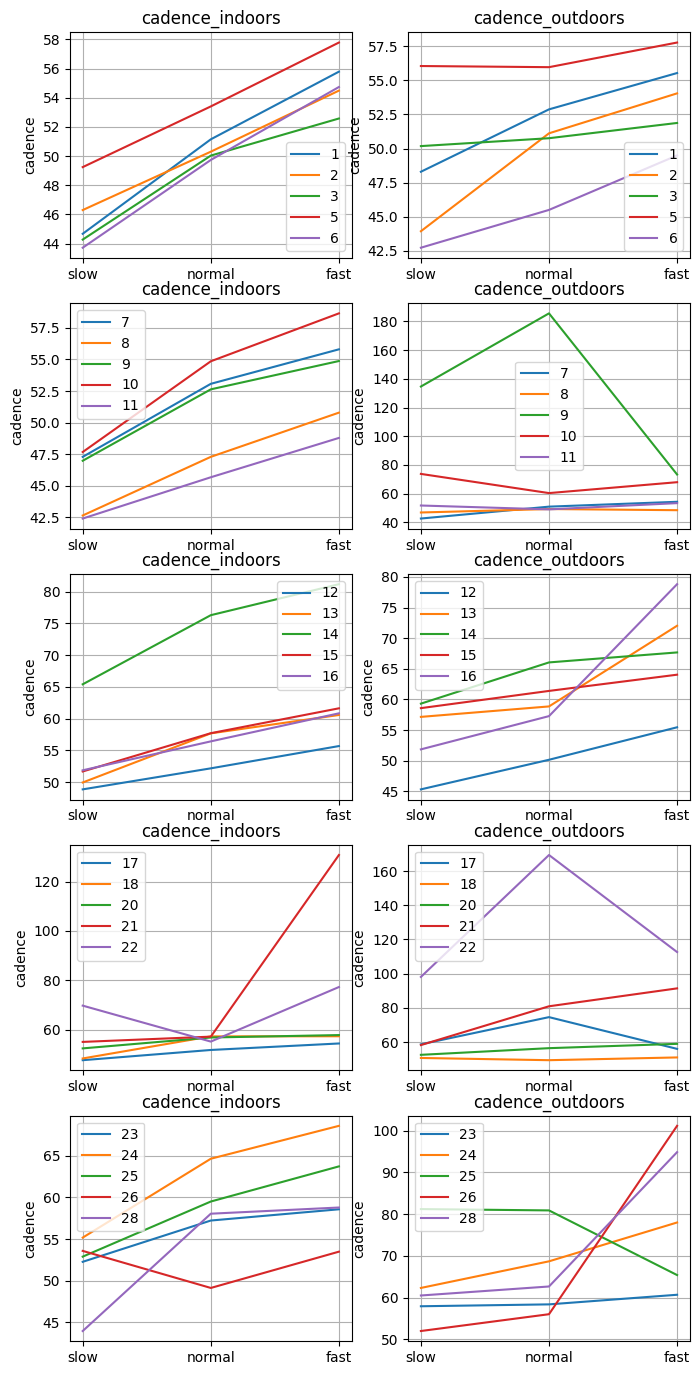

In [ ]:
line_plot_cadence()

In [ ]:
outliers=cadence_remove_outlier()

looking at file Analysis/slow/stats_of_gate_lengths/per_subject_AngularVelocityY(rad-s).3_left.csv
indoors slow 8 	 42.573810464271794 49.47108748120509 5.977213577838684
indoors slow 14 	 65.25937275887968 49.47108748120509 5.977213577838684
indoors slow 11 	 42.37658125144696 49.47108748120509 5.977213577838684
indoors slow 22 	 68.52436686653105 49.47108748120509 5.977213577838684
indoors slow 48.64
outdoors slow 9 	 138.13868658493615 59.97430090689981 18.876952203340647
outdoors slow 22 	 93.28423314769256 59.97430090689981 18.876952203340647
outdoors slow 25 	 81.6962317484431 59.97430090689981 18.876952203340647
outdoors slow 29 	 83.5190597403165 59.97430090689981 18.876952203340647
outdoors slow 53.7
looking at file Analysis/normal/stats_of_gate_lengths/per_subject_AngularVelocityY(rad-s).3_left.csv
indoors normal 8 	 47.31072447495112 54.69882940550016 5.65676256605265
indoors normal 11 	 45.79005459262168 54.69882940550016 5.65676256605265
indoors normal 14 	 76.401746646452

In [ ]:
df = one_subject_summary(24)

looking at file Analysis/slow/stats_of_gate_lengths/per_subject_AngularVelocityY(rad-s).3_left.csv
looking at file Analysis/normal/stats_of_gate_lengths/per_subject_AngularVelocityY(rad-s).3_left.csv
looking at file Analysis/fast/stats_of_gate_lengths/per_subject_AngularVelocityY(rad-s).3_left.csv


In [ ]:
df_compare=pull_together_across_speeds()
df_compare

IndexError: ignored

#### Cadence Similarity

In [ ]:
def fluff_shape(pace1_data, pace2_data):
  while pace2_data.shape[0]<pace1_data.shape[0]:
    pace2_data = np.append(pace2_data, pace2_data.mean())
  while pace1_data.shape[0]<pace2_data.shape[0]:
    pace1_data = np.append(pace1_data, pace1_data.mean())
  #print("shape 1",  pace1_data.shape, "shape 2",  pace2_data.shape)
  return pace1_data, pace2_data

In [ ]:
def pace_similarity(pace1, pace2, compare_cadence, inout, alpha):
  pace1_data = compare_cadence[pace1][inout]
  pace2_data= compare_cadence[pace2][inout]
  pace1_data, pace2_data= fluff_shape(pace2_data,pace1_data)
  #print("shape 1", pace1, pace1_data.shape, "shape 2", pace2, pace2_data.shape)
  z_score, cohens_d=poincare_z_score_cohens_d(pace1_data, pace2_data)
  shapiro_statistic_pace1_data, p_pace1_data = shapiro(pace1_data)
  shapiro_statistic_pace2_data, p_pace2_data = shapiro(pace2_data)
  if (p_pace1_data >alpha) and (p_pace2_data> alpha):
    test_stat, p_value=calc_t_test_poincare(pace1_data, pace2_data)
    test_type='t_test'
  else:
    test_stat, p_value=calc_wilcoxon_poincare(pace1_data, pace2_data)
    test_type='wilcoxon'
  row = {'label':inout+'_'+pace1+"_vs_"+pace2,'inout':inout, "pace1":pace1,
         'shapiro_stat_pace1':shapiro_statistic_pace1_data,
         'shapiro_p_val_pace1':p_pace1_data, "pace2":pace2,
         'shapiro_stat_pace2':shapiro_statistic_pace2_data,
         'shapiro_p_val_pace2':p_pace2_data,
         'test_type':test_type, 'stat':test_stat, 'p_value':p_value,
         'z_score':z_score, "cohens_d":cohens_d}
  return row


In [ ]:
def cadence_similarity_across_speeds(base_dir, save=True):
  '''pulls the cadence values together across speeds'''
  if save:
    cadence_dir =os.path.join(base_dir, 'cadence')
    if not os.path.exists(cadence_dir):
      os.mkdir(cadence_dir)
  compare_cadence = {}
  indoor_vs_outdoor_data = []
  speed_compare = []
  for speed in ['slow', 'normal','fast']:
    lookup_dir = os.path.join(base_dir,speed, 'stats_of_gate_lengths')
    filename = glob.glob(os.path.join(lookup_dir,"per_subject_*.csv"))[0]
    print("looking at file", filename)
    df_cadence=pd.read_csv(filename)
    indoors = df_cadence[df_cadence['inout']=='indoors']['cadence_avg_step_p_minute'].values
    outdoors = df_cadence[df_cadence['inout']=='outdoors']['cadence_avg_step_p_minute'].values
    compare_cadence[speed] = {'indoors':indoors, 'outdoors':outdoors}
    indoor_row, outdoor_row = indoor_outdoor_similarity(indoors, outdoors, speed, alpha=0.05)
    indoor_vs_outdoor_data.extend([indoor_row, outdoor_row])
  for inout in ['indoors', 'outdoors']:
    row = pace_similarity('normal', 'slow', compare_cadence, inout,  alpha=0.05)
    speed_compare.append(row)
    row = pace_similarity('normal','fast', compare_cadence, inout,  alpha=0.05)
    speed_compare.append(row)
    row = pace_similarity('fast','slow', compare_cadence, inout,  alpha=0.05)
    speed_compare.append(row)
  df_compare = pd.DataFrame(speed_compare)
  df_ivso = pd.DataFrame(indoor_vs_outdoor_data)
  if save:
    df_ivso.to_csv(os.path.join(cadence_dir, "indoor_vs_outdoor_similarity.csv"))
    df_compare.to_csv(os.path.join(cadence_dir, "speed_similarity.csv"))
  return df_compare, df_ivso

In [ ]:
cdf, iodf = cadence_similarity_across_speeds(os.path.join("Analysis", "05_13_23", "cadence_filtered"), save=True)

looking at file Analysis/05_13_23/cadence_filtered/slow/stats_of_gate_lengths/per_subject_AngularVelocityY(rad-s).3_left.csv
looking at file Analysis/05_13_23/cadence_filtered/normal/stats_of_gate_lengths/per_subject_AngularVelocityY(rad-s).3_left.csv
looking at file Analysis/05_13_23/cadence_filtered/fast/stats_of_gate_lengths/per_subject_AngularVelocityY(rad-s).3_left.csv


In [ ]:
iodf

,source,inout,avg,std,shapiro_stat,shapiro_p_val,test_type,stat,p_value,z_score,cohens_d
0,slow,indoors,47.989809,2.524103,0.942097,0.375496,NaN,NaN,NaN,NaN,NaN
1,slow,outdoors,53.644041,6.912922,0.927286,0.220736,t_test,-3.259184,0.005283,2.240096,1.086553
2,normal,indoors,53.872434,2.829903,0.885952,0.039752,NaN,NaN,NaN,NaN,NaN
3,normal,outdoors,57.421022,8.337345,0.783218,0.001205,wilcoxon,37.000000,0.063828,1.253961,0.569987
4,fast,indoors,56.624453,2.415347,0.967973,0.804797,NaN,NaN,NaN,NaN,NaN
5,fast,outdoors,59.638478,7.547858,0.867700,0.025083,wilcoxon,38.000000,0.129730,1.247864,0.537858


In [ ]:
cdf

,label,inout,pace1,shapiro_stat_pace1,shapiro_p_val_pace1,pace2,shapiro_stat_pace2,shapiro_p_val_pace2,test_type,stat,p_value,z_score,cohens_d
0,indoors_normal_vs_slow,indoors,normal,0.846848,5.329993e-04,slow,0.852124,6.870941e-04,wilcoxon,77.0,0.000872,0.889564,0.906366
1,indoors_normal_vs_fast,indoors,normal,0.548357,1.807962e-08,fast,0.852124,6.870941e-04,wilcoxon,59.0,0.000153,-0.429836,-0.565581
2,indoors_fast_vs_slow,indoors,fast,0.846097,6.328005e-04,slow,0.549051,2.636606e-08,wilcoxon,39.0,0.000028,1.907302,1.021603
3,outdoors_normal_vs_slow,outdoors,normal,0.695088,1.324514e-06,slow,0.573250,3.495017e-08,wilcoxon,141.0,0.060565,0.345982,0.264996
4,outdoors_normal_vs_fast,outdoors,normal,0.867101,1.444970e-03,fast,0.573250,3.495017e-08,wilcoxon,159.0,0.134735,-0.020497,-0.014026
5,outdoors_fast_vs_slow,outdoors,fast,0.696438,1.870908e-06,slow,0.864251,1.515017e-03,wilcoxon,118.0,0.030801,0.357462,0.383622


#### WARNING, REMOVES OUTLIERS IN DATA

stop

In [ ]:
with open(os.path.join("Analysis", 'cadence','outliers.pickle'),'rb') as fileobj:
  outliers = pickle.load(fileobj)
for subj in outliers:
  metadata = metadata[metadata['subjectID']!=subj]
print(metadata[metadata['inout']=='indoors'])

FileNotFoundError: ignored

### Poincare Analysis - Definition

https://sciendo.com/article/10.2478/slgr-2013-0031

In [ ]:
!pip install pyhrv
import pyhrv
import pyhrv.nonlinear as nl
import biosppy
from biosppy.signals.ecg import ecg
import matplotlib as mpl
print("pyhrv package version",pyhrv.__version__)
print("biosppy package version",biosppy.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.8/230.8 kB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for spectrum: filename=spectrum-0.8.1-cp310-cp310-linux_x86_64.whl size=237791 sha256=2b9d4f7341b7941cf20cc57c49dd860eb5a9fc7fb5d65635676e7f8ea89a1664
  Stored in directory: /root/.cache/pip/wheels/e7/5a/09/ffc6afdf8a5a6f58e9851292108df32bb11374e11b8705cabd
  Created wheel for easydev: filename=easydev-0.12.1-py3-none-any.whl size=64214 sha256=5189df393663e5c0d6bbf302a6b206c8f94f2465cf4156bb1782519c11bdcf30
  Stored in directory: /root/.cache/pip/wheels/c5/a3/df/e8e19f6f1674c2b0574ccc1a156292b599709eaa4feeea0fcf
Successfully built spectrum easydev
pyhrv package version 0.4.1

In [ ]:
def poincare(nni=None,
			 rpeaks=None,
			 show=True,
			 figsize=None,
			 ellipse=True,
			 vectors=True,
			 legend=True,
			 marker='o',
       title = 'Poincare Plot',
			 mode='normal',
			 xlim=None,
			 ylim=None):
	"""Creates Poincaré plot from a series of NN intervals or R-peak locations and derives the Poincaré related
	parameters SD1, SD2, SD1/SD2 ratio, and area of the Poincaré ellipse.
	References: [Tayel2015][Brennan2001]
	Parameters
	----------
	nni : array
		NN intervals in [ms] or [s]
	rpeaks : array
		R-peak times in [ms] or [s]
	show : bool, optional
		If true, shows Poincaré plot (default: True)
	show : bool, optional
		If true, shows generated plot
	figsize : array, optional
		Matplotlib figure size (width, height) (default: (6, 6))
	ellipse : bool, optional
		If true, shows fitted ellipse in plot (default: True)
	vectors : bool, optional
		If true, shows SD1 and SD2 vectors in plot (default: True)
	legend : bool, optional
		If True, adds legend to the Poincaré plot (default: True)
	marker : character, optional
		NNI marker in plot (default: 'o')
		mode : string, optional
	Return mode of the function; available modes:
		'normal'	Returns frequency domain parameters and PSD plot figure in a ReturnTuple object
		'dev'		Returns frequency domain parameters, frequency and power arrays, no plot figure
	Returns (biosppy.utils.ReturnTuple Object)
	------------------------------------------
	[key : format]
		Description.
	poincare_plot : matplotlib figure object
		Poincaré plot figure
	sd1 : float
		Standard deviation (SD1) of the major axis
	sd2 : float, key: 'sd2'
		Standard deviation (SD2) of the minor axis
	sd_ratio: float
		Ratio between SD2 and SD1 (SD2/SD1)
	ellipse_area : float
		Area of the fitted ellipse
	"""
	# Check input values
	nn = pyhrv.utils.check_input(nni, rpeaks)/1000

	# Prepare Poincaré data
	x1 = np.asarray(nn[:-1])
	x2 = np.asarray(nn[1:])

	# SD1 & SD2 Computation
	sd1 = np.std(np.subtract(x1, x2) / np.sqrt(2))
	sd2 = np.std(np.add(x1, x2) / np.sqrt(2))

	# Area of ellipse
	area = np.pi * sd1 * sd2

	# Dev:
	# Output computed SD1 & SD2 without plot
	if mode == 'dev':
		# Output
		args = (sd1, sd2, sd2 / sd1, area)
		names = ('sd1', 'sd2', 'sd_ratio', 'ellipse_area')
		return biosppy.utils.ReturnTuple(args, names)

	# Normal:
	# Same as dev but with plot
	if mode == 'normal':
		if figsize is None:
			figsize = (6, 6)
		fig = plt.figure(figsize=figsize)
		fig.tight_layout()
		ax = fig.add_subplot(111)

		ax.set_title(title)
		ax.set_ylabel('x(n+1)')
		ax.set_xlabel('x(n)')
		if xlim:
			ax.set_xlim(xlim)
		else:
			ax.set_xlim([np.min(nn) - 0.5, np.max(nn) + 0.5])
		if ylim:
			ax.set_ylim(ylim)
		else:
			ax.set_ylim([np.min(nn) - 0.5, np.max(nn) + 0.5])
		ax.grid()
		ax.plot(x1, x2, 'r%s' % marker, markersize=2, alpha=0.5, zorder=3)

		# Compute mean NNI (center of the Poincaré plot)
		nn_mean = np.mean(nn)

		# Draw poincaré ellipse
		if ellipse:
			ellipse_ = mpl.patches.Ellipse((nn_mean, nn_mean), sd1 * 2, sd2 * 2, angle=-45, fc='k', zorder=1)
			ax.add_artist(ellipse_)
			ellipse_ = mpl.patches.Ellipse((nn_mean, nn_mean), sd1 * 2 - 1, sd2 * 2 - 1, angle=-45, fc='lightyellow', zorder=1)
			ax.add_artist(ellipse_)

		# Add poincaré vectors (SD1 & SD2)
		if vectors:
			arrow_head_size = 0.1
			na = 2
			a1 = ax.arrow(
				nn_mean, nn_mean, (-sd1 + na) * np.cos(np.deg2rad(45)), (sd1 - na) * np.sin(np.deg2rad(45)),
				head_width=arrow_head_size, head_length=arrow_head_size, fc='g', ec='g', zorder=4, linewidth=1.5)
			a2 = ax.arrow(
				nn_mean, nn_mean, (sd2 - na) * np.cos(np.deg2rad(45)), (sd2 - na) * np.sin(np.deg2rad(45)),
				head_width=arrow_head_size, head_length=arrow_head_size, fc='b', ec='b', zorder=4, linewidth=1.5)
			a3 = mpl.patches.Patch(facecolor='white', alpha=0.0)
			a4 = mpl.patches.Patch(facecolor='white', alpha=0.0)
			ax.add_line(mpl.lines.Line2D(
				(min(nn), max(nn)),
				(min(nn), max(nn)),
				c='b', ls=':', alpha=0.6))
			ax.add_line(mpl.lines.Line2D(
				(nn_mean - sd1 * np.cos(np.deg2rad(45)) * na, nn_mean + sd1 * np.cos(np.deg2rad(45)) * na),
				(nn_mean + sd1 * np.sin(np.deg2rad(45)) * na, nn_mean - sd1 * np.sin(np.deg2rad(45)) * na),
				c='g', ls=':', alpha=0.6))

			# Add legend
			if legend:
				ax.legend(
					[a1, a2, a3, a4],
					['SD1: %.3f' % sd1, 'SD2: %.3f' % sd2, 'Area: %.3f' % area, 'SD1/SD2: %.3f' % (sd1/sd2)],
					framealpha=1)

		# Show plot
		if show:
			plt.show()

		# Output
		args = (fig, sd1, sd2, sd2/sd1, area)
		names = ('poincare_plot', 'sd1', 'sd2', 'sd_ratio', 'ellipse_area')
		return biosppy.utils.ReturnTuple(args, names)

In [ ]:
def graph_poincare_per_leg(data_lookup, metadata, zero_crossing_lookup, sensor, save_dir):
  ''' for single sensor, for indoors and out, for each subject do poincare on the
  avg signal '''
  area=COLUMNS_TO_AREA[sensor]
  save_dir = os.path.join(save_dir,sensor.replace(os.path.sep, "-").replace(" ", '')+'_'+area.replace(' ',"_"))
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  data_poincare=[]
  print("pace",metadata['pace'].unique())
  for inout in ['indoors', 'outdoors']:
    for subjectID in  metadata['subjectID'].unique():
      all_gates = aggregate_single_subject(data_lookup, metadata, zero_crossing_lookup, sensor, inout , subjectID)
      avg =all_gates.mean(axis=0)
      title = "{} {} {} subjectID: {}".format(sensor,area, inout,subjectID)
      figname = "{}_{}_{}_{}.png".format(sensor.replace(os.path.sep, "-"),area, inout,subjectID)
      results = poincare(avg, title=title, show=False)
      fig = results['poincare_plot']
      columns = ['sensor','area','inout', 'subjectID', 'sd1', 'sd2', 'sd_ratio', 'ellipse_area']
      data_poincare.append([sensor,area, inout,subjectID,
                            results['sd1'], results['sd2'], results['sd_ratio'],
                            results['ellipse_area']])
      fig.savefig(os.path.join(save_dir, figname))
      plt.close()
      time.sleep(0.1)
  df_poincare = pd.DataFrame(data_poincare, columns=columns)
  df_poincare.to_csv(os.path.join(save_dir,'poincare_sd.csv'), index=False)

In [ ]:
def graph_poincare_comb_leg_per_sensor(combined_legs, sensor, save_dir_m, ylim=None, xlim=None):
  ''' for single sensor - combined across legs, for indoors and out, aggregate
  across all subjects do poincare on the avg signal '''
  save_dir = os.path.join(save_dir_m,sensor.replace(os.path.sep, "-").replace(" ", '').replace("^",'-'))
  #print("saving at",save_dir)
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  data_poincare=[]
  for inout in ['indoors', 'outdoors']:
    avg_signal = combined_legs[sensor][inout]['avg']
    title = "{} {}".format(sensor, inout)
    figname = "{}_{}.png".format(sensor.replace(os.path.sep, "-"), inout)
    results = poincare(avg_signal, title=title, show=False, ylim=ylim, xlim=xlim)
    fig = results['poincare_plot']
    columns = ['sensor','inout', 'sd1', 'sd2', 'sd_ratio', 'ellipse_area']
    data_poincare.append([sensor, inout,
                          results['sd1'], results['sd2'], results['sd_ratio'],
                          results['ellipse_area']])
    fig.savefig(os.path.join(save_dir, figname))
    plt.close()
    time.sleep(0.1)
  df_poincare = pd.DataFrame(data_poincare, columns=columns)
  df_poincare.to_csv(os.path.join(save_dir,'poincare_sd.csv'), index=False)
def graph_poincare_comb_leg(combined_legs, save_dir_m):
  print("pace",metadata['pace'].unique()[0])
  for sensor in list(combined_legs.keys()):
    graph_poincare_comb_leg_per_sensor(combined_legs, sensor, save_dir_m)

In [ ]:
def graph_poincare_comb_leg_per_sensor_per_subject(metadata,data_lookup,zero_crossing_lookup, sensor_cols, save_dir_m ,ylim=None, xlim=None):
  ''' for single sensor - combined legs, for indoors and out, for each subject do poincare on the
  avg signal '''
  sensor_name = sensor_cols['left'].replace(".1",' '+sensor_cols['sensor']).replace(".3",' '+sensor_cols['sensor'])
  save_dir = os.path.join(save_dir_m,sensor_name.replace(os.path.sep,'-'))
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  rows = []
  for subjectID in  metadata['subjectID'].unique():
      indoors, outdoors = combine_legs_single_subject(sensor_name,data_lookup, metadata, zero_crossing_lookup, sensor_cols, subjectID )
      for signal, inout in [(indoors,'indoors'), (outdoors, 'outdoors')]:
        title = "{} {} subject:{}".format(sensor_name, inout, subjectID)
        figname = "{}_{}_subject{}.png".format(sensor_name.replace(os.path.sep,'-'), inout, subjectID)

        results = poincare(signal, title=title, show=False, ylim=ylim, xlim=xlim)
        fig = results['poincare_plot']
        rows.append({"sensor":sensor_name, "subjectID":subjectID, "inout":inout,
                     'sd1':results['sd1'] ,"sd2":results['sd2'],
                     "sd_ration":results['sd_ratio'],
                     "ellipse_area":results['ellipse_area'],
                          })
        fig.savefig(os.path.join(save_dir, figname))
        plt.close()
        time.sleep(0.1)
  return rows
def graph_poincare_comb_leg_per_subject(metadata,data_lookup,zero_crossing_lookup, save_dir):
  '''loops through all the sensors to call graph_poincare_comb_leg_per_sensor_per_subject'''
  print('pace',metadata['pace'].unique())
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  df_poincare_p_subject= pd.DataFrame()
  for sensor_cols in COLUMNS_BY_SENSOR:
    #print(sensor_name)
    rows =graph_poincare_comb_leg_per_sensor_per_subject(metadata,data_lookup,zero_crossing_lookup, sensor_cols, save_dir)
    df_poincare_p_subject = pd.concat([df_poincare_p_subject, pd.DataFrame(rows)])
  df_save_path = os.path.join(save_dir, "poincare_p_subject.csv")
  df_poincare_p_subject.to_csv(df_save_path, index=False)
  print(df_save_path)
  return df_poincare_p_subject

In [ ]:
def get_sub_poincare(df_poincare_p_subject, sensor, inout, col):
  sub = df_poincare_p_subject[(df_poincare_p_subject['sensor']==sensor )& (df_poincare_p_subject['inout']==inout) ]
  return sub[col].values
def poincare_sim_stats_per_sensor(SAVE_DIR, alpha = 0.05):
  '''using sd1 and sd2 to calculate sim stats for each sensor
  must be run after graph_poincare_comb_leg_per_subject to load the data for each
  subject indoor and outdoor so that can be fed into the similarity calc'''
  lookup_dir = os.path.join(SAVE_DIR, 'poincare',"per_subject")
  lookup_df_path = os.path.join(lookup_dir,"poincare_p_subject.csv")
  print(lookup_df_path)
  df_poincare_p_subject = pd.read_csv(lookup_df_path)
  poin_stats_data = []
  for sensor in list(df_poincare_p_subject['sensor'].unique()):
    for col in ['sd1', 'sd2']:
      indoors = get_sub_poincare(df_poincare_p_subject, sensor, 'indoors', col)
      outdoors = get_sub_poincare(df_poincare_p_subject, sensor, 'outdoors', col)
      in_row, out_row = indoor_outdoor_similarity(indoors, outdoors, col, alpha)
      in_row['sensor'] = sensor
      out_row['sensor'] = sensor
      poin_stats_data.extend([in_row, out_row])
  poin_stats = pd.DataFrame(poin_stats_data)
  poin_stats.to_csv(os.path.join(lookup_dir, 'poincare_sim_stats_per_sensor.csv'), index=False)

In [ ]:
start = datetime.datetime.now()
combined_legs= aggregate_subjects_trials_legs(data_lookup, metadata, zero_crossing_lookup)
print(combined_legs.keys())
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

In [ ]:
start = datetime.datetime.now()
save_dir = os.path.join(SAVE_DIR, 'poincare',"per_subject")
df_poincare_p_subject = graph_poincare_comb_leg_per_subject(metadata,data_lookup,zero_crossing_lookup,save_dir)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

In [ ]:
poincare_sim_stats_per_sensor()

In [ ]:
start = datetime.datetime.now()
save_dir = os.path.join(SAVE_DIR, 'poincare')
if not os.path.exists(save_dir):
  os.mkdir(save_dir)
sens = LEFT_AVY_HEADER
graph_poincare_per_leg(data_lookup, metadata, zero_crossing_lookup, sens, save_dir)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

In [ ]:
combined_legs

In [ ]:
start = datetime.datetime.now()
save_dir = os.path.join(SAVE_DIR, 'poincare')
if not os.path.exists(save_dir):
  os.mkdir(save_dir)
graph_poincare_comb_leg(combined_legs, save_dir)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")


In [ ]:
save_dir = os.path.join(SAVE_DIR, 'poincare')
for sensor in ['Acceleration Y (m/s^2) shank', 'Angular Velocity Y (rad/s) shank']:
  graph_poincare_comb_leg_per_sensor(combined_legs, sensor, save_dir, xlim=[-7,4], ylim=[-7,4])

### Poincare Stats

In [ ]:
def poincare_z_score_cohens_d(indoors, outdoors):
  indoors_std = indoors.std()
  outdoors_mean=outdoors.mean()
  indoors_mean= indoors.mean()
  #print("indoor mean", indoors_mean, "std", indoors_std)
  z_score =  (outdoors_mean-indoors_mean)/indoors_std
  cohens_d = (outdoors_mean-indoors_mean)/np.sqrt((indoors_std**2+outdoors.std()**2)/2)
  return z_score, cohens_d
def load_poincare_data(save_dir):
  list_dirs = [x for x in os.listdir(save_dir) if 'left' not in x]
  list_dirs = [x for x in list_dirs if 'right' not in x]
  list_dirs = [x for x in list_dirs if os.path.isdir(os.path.join(save_dir,x))]
  print("dirs looking in", save_dir)
  print(list_dirs)
  all_poincare_stats = pd.DataFrame()
  for dr in list_dirs:
    csv = glob.glob(os.path.join(save_dir, dr, "*.csv"))
    all_poincare_stats = pd.concat([all_poincare_stats, pd.read_csv(csv[0])])
  return all_poincare_stats

In [ ]:
def indoor_outdoor_similarity(indoors, outdoors, col, alpha):
  z_score, cohens_d=poincare_z_score_cohens_d(indoors, outdoors)
  shapiro_statistic_indoors, p_indoors = shapiro(indoors)
  shapiro_statistic_outdoors, p_outdoors = shapiro(outdoors)
  if (p_indoors >alpha) and (p_outdoors> alpha):
    test_stat, p_value=calc_t_test_poincare(indoors, outdoors)
    test_type='t_test'
  else:
    test_stat, p_value=calc_wilcoxon_poincare(indoors, outdoors)
    test_type='wilcoxon'
  indoor_row = {'source':col,'inout':'indoors', 'avg':indoors.mean(), 'std':indoors.std(), 'shapiro_stat':shapiro_statistic_indoors,
                'shapiro_p_val':p_indoors}
  outdoor_row = {'source':col,'inout':'outdoors', 'avg':outdoors.mean(), 'std':outdoors.std(), 'shapiro_stat':shapiro_statistic_outdoors,
                'shapiro_p_val':p_outdoors, 'test_type':test_type, 'stat':test_stat, 'p_value':p_value,
                'z_score':z_score, "cohens_d":cohens_d}
  return [indoor_row, outdoor_row]

In [ ]:
def calc_wilcoxon_poincare(indoors, outdoors):
  alternative = 'two-sided'
  zero_method = 'wilcox'
  w_statistic, p_value = wilcoxon(indoors, outdoors,alternative=alternative,  zero_method= zero_method)
  return w_statistic, p_value
def calc_t_test_poincare(indoors, outdoors):
  alternative = 'two-sided'
  ttest = ttest_rel
  t_statistic, p_value = ttest(indoors, outdoors,alternative=alternative )
  return t_statistic, p_value
def calculate_poincare_stats(alpha = 0.05):
  '''calc poincare using the values from each signal as the data for the lists
  to compare indoor and outdoor'''
  save_dir = os.path.join(SAVE_DIR, 'poincare')
  all_poincare_data= load_poincare_data(save_dir)
  poin_stats_data = []
  for col in ['sd1', 'sd2']:
    indoors = all_poincare_data[all_poincare_data['inout']=='indoors'][col].values
    outdoors = all_poincare_data[all_poincare_data['inout']=='outdoors'][col].values
    poin_stats_data.extend(indoor_outdoor_similarity(indoors, outdoors, col, alpha))
  poin_stats = pd.DataFrame(poin_stats_data)
  poin_stats.to_csv(os.path.join(save_dir, 'poincare_sim_stats.csv'), index=False)
  #print("indoor mean", indoors.mean(), "std", indoors.std())
  return poin_stats

In [ ]:
poin_stats=calculate_poincare_stats()

dirs looking in Analysis/normal/poincare
['AccelerationY(m-s-2)thigh', 'AngularVelocityY(rad-s)thigh', 'AccelerationY(m-s-2)shank', 'AngularVelocityY(rad-s)shank', 'AccelerationX(m-s-2)thigh', 'AccelerationZ(m-s-2)thigh', 'AngularVelocityX(rad-s)thigh', 'AngularVelocityZ(rad-s)thigh', 'AccelerationX(m-s-2)shank', 'AccelerationZ(m-s-2)shank', 'AngularVelocityX(rad-s)shank', 'AngularVelocityZ(rad-s)shank', 'per_subject']
indoor mean 2.2963325990582817 std 1.8085260692422294


In [ ]:
poin_stats

,source,inout,avg,std,shapiro_stat,shapiro_p_val,test_type,stat,p_value,z_score,cohens_d
0,sd1,indoors,0.237035,0.237415,0.842907,0.030040,NaN,NaN,NaN,NaN,NaN
1,sd1,outdoors,0.254328,0.254780,0.846562,0.033303,wilcoxon,8.000000,0.012207,0.072838,0.070224
2,sd2,indoors,1.823769,1.385755,0.909404,0.209627,NaN,NaN,NaN,NaN,NaN
3,sd2,outdoors,2.003079,1.589534,0.878044,0.082737,t_test,-2.162803,0.053443,0.129395,0.120251


## reformatting results

In [ ]:
def re_format_poincare_sim_stats(base_dir = os.path.join('Analysis')):
  df=pd.DataFrame()
  for speed in ['normal', 'slow', 'fast']:
    load_dir = os.path.join(base_dir, speed,'poincare', 'per_subject')
    df_p = pd.read_csv(os.path.join(load_dir, 'poincare_sim_stats_per_sensor.csv'))
    df_p['pace']=speed
    df = pd.concat([df, df_p])
  sensors = list(df['sensor'].unique())
  new_table = []
  test_type_table = []
  for sensor in sensors:
    subdf = df[(df['sensor']==sensor)&(df['inout']=='outdoors')]
    row = [sensor]
    test_type_row = [sensor]
    column_names = ['sensor']
    test_type_names = ['sensor']
    for speed in ['normal', 'slow', 'fast']:
      for sd in ['sd1', 'sd2']:
        test_type_row.append(subdf[(subdf['source']==sd)&(subdf['pace']==speed)]['test_type'].iloc[0])
        test_type_names.append(speed +' '+sd)
        for metric in ['p_value', 'z_score']:
          column_names.append(speed +' '+sd+' '+metric)
          cond = (subdf['source']==sd)&(subdf['pace']==speed)
          val=subdf[cond][metric].iloc[0]
          row.append(val)
    new_table.append(row)
    test_type_table.append(test_type_row)
  new_table= pd.DataFrame(new_table, columns=column_names)
  new_table.to_csv(os.path.join(base_dir, 'trends_across_pace', 'poincare_sim_stats.csv'), index=False)
  test_table= pd.DataFrame(test_type_table, columns=test_type_names)
  test_table.to_csv(os.path.join(base_dir, 'trends_across_pace', 'poincare_sim_stats_test_types.csv'), index=False)


In [ ]:
def re_formatting_peak(base_dir = os.path.join('Analysis')):
  df=pd.DataFrame()
  for speed in ['normal', 'slow', 'fast']:
    load_dir = os.path.join(base_dir, speed,'peaks_per_subject', 'gaussian_analysis')
    df_p = pd.read_csv(os.path.join(load_dir, 'combined_legs_test_t_and_wilcoxon.csv'))
    df_p['pace']=speed
    df = pd.concat([df, df_p])
  sensors = list(df['source'].unique())
  new_table = []
  test_type_data = []
  for sensor in sensors:
    row = [sensor]
    test_row = [sensor]
    column_names = ['sensor']
    subdf = df[(df['source']==sensor)]
    for speed in ['normal', 'slow', 'fast']:
      for metric in ['avg_peak',  'avg_range','avg_valley']:
        cond = (subdf['data']==metric)&(subdf['pace']==speed)
        column_names.append(speed+'_'+metric)
        assert len(subdf[cond]['p_value'].to_numpy())==1
        row.append(subdf[cond]['p_value'].iloc[0])
        test_row.append(subdf[cond]['test_type'].iloc[0])
    new_table.append(row)
    test_type_data.append(test_row)
  new_table= pd.DataFrame(new_table, columns=column_names)
  new_table.to_csv(os.path.join(base_dir,'trends_across_pace', 'peak_valley_sim_stats.csv'), index=False)
  test_type_table= pd.DataFrame(test_type_data, columns=column_names)
  test_type_table.to_csv(os.path.join(base_dir,'trends_across_pace', 'peak_valley_sim_stats_test_type.csv'), index=False)

  new_table = []
  test_type_data = []
  sensors = list(df[df['data']=='avg_gate_length']['source'].unique())
  for sensor in sensors:
    row = [sensor]
    test_row=[sensor]
    column_names = ['sensor']
    subdf = df[(df['source']==sensor)]
    for speed in ['normal', 'slow', 'fast']:
      for metric in ['avg_swing_index','avg_gate_length']:
        cond = (subdf['data']==metric)&(subdf['pace']==speed)
        column_names.append(speed+'_'+metric)
        assert len(subdf[cond]['p_value'].to_numpy())==1
        row.append(subdf[cond]['p_value'].iloc[0])
        test_row.append(subdf[cond]['test_type'].iloc[0])
    new_table.append(row)
    test_type_data.append(test_row)
  new_table= pd.DataFrame(new_table, columns=column_names)
  new_table.to_csv(os.path.join(base_dir,'trends_across_pace', 'gate_swing_sim_stats.csv'), index=False)
  test_type_table= pd.DataFrame(test_type_data, columns=column_names)
  test_type_table.to_csv(os.path.join(base_dir,'trends_across_pace', 'gate_swing_sim_stats_test_type.csv'), index=False)




In [ ]:
def re_format_distance_sim(base_dir = os.path.join('Analysis')):
  df=pd.DataFrame()
  for speed in ['normal', 'slow', 'fast']:
    load_dir = os.path.join(base_dir, speed,'combined_subjects_and_trials_and_legs')
    df_p = pd.read_csv(os.path.join(load_dir, 'signal_similarity_combined_legs.csv'))
    df_p['pace']=speed
    df = pd.concat([df, df_p])
  sensors = list(df['sensor'].unique())
  new_table = []
  for sensor in sensors:
    subdf = df[(df['sensor']==sensor)]
    row = [sensor]
    test_type_row = [sensor]
    column_names = ['sensor' ]
    for speed in ['normal', 'slow', 'fast']:
      assert len(subdf[subdf['pace']==speed]['cosine_similarity'].to_numpy())==1
      row.extend([subdf[subdf['pace']==speed]['cosine_similarity'].iloc[0], subdf[subdf['pace']==speed]['euclidean_distance'].iloc[0]])
      column_names.extend([speed+'_cosine', speed+'_euclidean'])
    new_table.append(row)
  new_table= pd.DataFrame(new_table, columns=column_names)
  new_table.to_csv(os.path.join(base_dir,'trends_across_pace', 'cos_euclidean_sim_stats.csv'), index=False)



In [ ]:
 'lrc_i.vs.o_cosine_similarity_test_p_value','lrc_i.vs.o_cosine_similarity_z_score', 'lrc_i.vs.o_euclidean_distance_test_p_value',  'lrc_i.vs.o_euclidean_distance_z_score'

lrc_i.vs.o_cosine_similarity_test_p_value

In [ ]:
def re_format_paired_comparison(base_dir = os.path.join('Analysis')):
  df=pd.DataFrame()
  for speed in ['normal', 'slow', 'fast']:
    load_dir = os.path.join(base_dir, speed,'similarity_per_subject')
    df_p = pd.read_csv(os.path.join(load_dir, 'lr_control_compare_lio_rio.csv'))
    df_p['pace']=speed
    df = pd.concat([df, df_p])
  sensors = list(df['sensor'].unique())
  new_table = []
  data_columns = [ 'lrc_i.vs.o_cosine_similarity_test_p_value',
                  'lrc_i.vs.o_cosine_similarity_z_score',
                  'lrc_i.vs.o_euclidean_distance_test_p_value',
                  'lrc_i.vs.o_euclidean_distance_z_score']
  test_type_data = []
  for sensor in sensors:
    subdf = df[(df['sensor']==sensor)]
    row = [sensor]
    test_row = [sensor]
    column_names = ['sensor' ]
    test_names = ['sensor' ]
    for speed in ['normal', 'slow', 'fast']:
      test_names.append(speed)
      test_row.append(subdf[subdf['pace']==speed]['test_type'].iloc[0])
      for head in data_columns:
        assert len(subdf[subdf['pace']==speed][head].to_numpy())==1,subdf[head].to_numpy()
        row.append(subdf[subdf['pace']==speed][head].iloc[0])
        column_names.append(speed+'_'+head)
    new_table.append(row)
    test_type_data.append(test_row)
  new_table= pd.DataFrame(new_table, columns=column_names)
  new_table.to_csv(os.path.join(base_dir,'trends_across_pace', 'paired_comparison_sim_stats.csv'), index=False)
  test_type_table= pd.DataFrame(test_type_data, columns=test_names)
  test_type_table.to_csv(os.path.join(base_dir,'trends_across_pace', 'paired_comparison_sim_stats_test_types.csv'), index=False)


In [ ]:
def z_score_directly(indoor_avg, indoor_std, outdoor_avg, outdoor_std):
  z_score  = (outdoor_avg-indoor_avg)/indoor_std
  cohens_d = (outdoor_avg-indoor_avg)/np.sqrt((indoor_std**2+outdoor_std**2)/2)
  return z_score, cohens_d

def extract_z_cohen_peak(sub_df_indoors, sub_df_outdoors, data_type):
  assert len(sub_df_indoors[sub_df_indoors['data']=='avg_'+data_type]['avg'])==1, sub_df_indoors[sub_df_indoors['data']=='avg_'+data_type]['avg']
  assert len(sub_df_outdoors[sub_df_outdoors['data']=='avg_'+data_type]['avg'])==1
  indoor_avg = sub_df_indoors[sub_df_indoors['data']=='avg_'+data_type]['avg'].iloc[0]
  outdoor_avg = sub_df_outdoors[sub_df_outdoors['data']=='avg_'+data_type]['avg'].iloc[0]
  indoor_std = sub_df_indoors[sub_df_indoors['data']=='avg_'+data_type]['std'].iloc[0]
  outdoor_std = sub_df_outdoors[sub_df_outdoors['data']=='avg_'+data_type]['std'].iloc[0]
  z_score, cohens_d = z_score_directly(indoor_avg, indoor_std, outdoor_avg, outdoor_std)
  return z_score, cohens_d


In [ ]:
def peak_z_score_cohens_d(base_dir):
  df_peak_avgs=pd.DataFrame()
  for speed in ['normal', 'slow', 'fast']:
    load_dir = os.path.join(base_dir, speed,"peaks_per_subject", 'gaussian_analysis')
    df_p = pd.read_csv(os.path.join(load_dir,'combined_legs_test_shapiro_wilk.csv'))
    df_p['pace']=speed
    df_peak_avgs = pd.concat([df_peak_avgs, df_p])
  list_sensors = list(df_peak_avgs['source'].unique())
  data = []
  print(df_peak_avgs['data'].unique())
  data_cohens = []
  for sensor in list_sensors:
    row_z = {"sensor": sensor}
    row_c = {"sensor": sensor}
    for speed in ['normal', 'slow', 'fast']:
      sub_df_indoors = df_peak_avgs[(df_peak_avgs['inout']=='indoors')&(df_peak_avgs['source']==sensor)&(df_peak_avgs['pace']==speed)]
      sub_df_outdoors = df_peak_avgs[(df_peak_avgs['inout']=='outdoors')&(df_peak_avgs['source']==sensor)&(df_peak_avgs['pace']==speed)]
      for data_type in ['peak','range', 'valley']:
        z_score, cohens_d = extract_z_cohen_peak(sub_df_indoors, sub_df_outdoors, data_type)
        row_z.update({speed+"_"+data_type+"_z_score":z_score})
        row_c.update({speed+"_"+data_type+"_cohens_d_score":cohens_d})
    data.append(row_z)
    data_cohens.append(row_c)
  df_z_score = pd.DataFrame(data)
  df_cohens_d = pd.DataFrame(data_cohens)
  df_z_score.to_csv(os.path.join(base_dir,"trends_across_pace","peak_z_score.csv"))
  df_z_score.to_csv(os.path.join(base_dir,"trends_across_pace","peak_cohens_d_score.csv"))

  data_c = []
  data_z = []
  list_sensors = list(df_peak_avgs[df_peak_avgs['data']=='avg_gate_length']['source'].unique())
  for sensor in list_sensors:
    row_z = {"sensor": sensor}
    row_c = {"sensor": sensor}
    for speed in ['normal', 'slow', 'fast']:
      for data_type in ['swing_index','gate_length']:
        sub_df = df_peak_avgs[(df_peak_avgs['pace']==speed)&(df_peak_avgs['source']==sensor)]
        z_score, cohens_d = extract_z_cohen_peak(sub_df[sub_df['inout']=='indoors'], sub_df[sub_df['inout']=='outdoors'], data_type)
        row_z.update({speed+"_"+data_type+"_z_score":z_score})
        row_c.update({speed+"_"+data_type+"_cohens_d_score":cohens_d})
    data_c.append(row_c)
    data_z.append(row_z)
  table_c= pd.DataFrame(data_c)
  table_z= pd.DataFrame(data_z)
  table_c.to_csv(os.path.join(base_dir,'trends_across_pace', 'gate_swing_cohens_d.csv'), index=False)
  table_z.to_csv(os.path.join(base_dir,'trends_across_pace', 'gate_swing_z_score.csv'), index=False)


In [ ]:
results_dir = os.path.join("Analysis/05_13_23")
#re_format_poincare_sim_stats(results_dir)
#re_formatting_peak(results_dir)
re_format_paired_comparison(results_dir)

In [ ]:
peak_z_score_cohens_d(os.path.join("Analysis", "05_13_23"))


['avg_peak' 'avg_valley' 'avg_range' 'avg_gate_length' 'avg_swing_index']


In [ ]:
re_formatting_peak()

In [ ]:
re_format_distance_sim()

In [ ]:
re_formatting_peak()
re_format_paired_comparison()
re_format_distance_sim()
re_format_poincare_sim_stats()

## Extract Peak Values Per Subject

In [ ]:
min_lookup = {}
all_mins = []
for file in data_lookup.keys():
  min_lookup[file] ={'left': data_lookup[file][LEFT_AVY_HEADER].min(), 'right':data_lookup[file][RIGHT_AVY_HEADER].min()}
  all_mins.append(data_lookup[file][LEFT_AVY_HEADER].min())
  all_mins.append(data_lookup[file][RIGHT_AVY_HEADER].min())
plt.hist(all_mins)
plt.title("hist of min values per file")
print("right and left shank values are both included in the hist")

In [ ]:
start = datetime.datetime.now()
gate_peak_valley_swing(metadata, data_lookup, zero_crossing_lookup, SAVE_DIR)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")


grabbing data for data streams/columns
error finding swing index
values used for swing index 128 values used for other calculations 129
sensor Angular Velocity Y (rad/s).2 subjectID 27
error finding swing index
values used for swing index 382 values used for other calculations 384
sensor Angular Velocity Y (rad/s).3 subjectID 14
error finding swing index
values used for swing index 134 values used for other calculations 135
sensor Angular Velocity Y (rad/s).3 subjectID 21
took 106.83063 to run


### Distribution of Peak Values - Shapiro Wilk & Gaussians

In [ ]:
legs = 2
areas = 2
axis =3
vel = 2
inout = 2
metric = 3
legs*areas*axis*vel*inout*metric +legs*1*1*1*inout*2

152

In [ ]:
start = datetime.datetime.now()
calc_shapiro_t_test(SAVE_DIR)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

took 95.31932 to run


In [ ]:
start = datetime.datetime.now()
calc_shapiro_t_test_legs_combined(SAVE_DIR)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

## Combine Gate Data from Single Sensor - Across Subjects

### Graphing Aggregated Signals

In [ ]:
##PICK ONE DATA STREAM AT A TIME
column_to_graph = COLUMNS_TO_GRAPH[random.randint(0,len(COLUMNS_TO_GRAPH)-1)]
inout='indoors'
plot_columns_inout(data_lookup, metadata, zero_crossing_lookup,column_to_graph, inout)

In [ ]:
start = datetime.datetime.now()
save_dir = os.path.join(SAVE_DIR, 'combined_subjects_and_trials')
if not os.path.exists(save_dir):
  os.mkdir(save_dir)
graph_sensors_combined_subjects_trials(save_dir, data_lookup, metadata, zero_crossing_lookup)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

### Signal Stats

In [ ]:
##for all data streams indoors, then outdoors. get max, min, range, avg,
##  std values. max and min values are from the raw signal per gate
##  not from the averaged values.
start = datetime.datetime.now()
global_mins, global_maxes, ranges = combined_subjects_trials_signal_stats(data_lookup, metadata, zero_crossing_lookup, SAVE_DIR)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

all values presented are done by analyzing a list of size ~9,198. Where each element in the list is a gate profile. Meaning the average min is the average of ~9,198 minimum values
took 108.786627 to run


In [ ]:
plt.hist(global_mins)
plt.title('global minimums across data streams')
plt.xlabel("global minimum of single data stream")

In [ ]:
plt.hist(global_maxes)
plt.title('global maximums across data streams')
plt.xlabel("global maximum of single data stream")

In [ ]:
plt.hist(ranges)
plt.title('range values across data streams')
plt.xlabel("amplitude range of a single data stream")

## Combine Subjects, Trials, and Legs

In [ ]:
start = datetime.datetime.now()
save_dir = os.path.join(SAVE_DIR, 'combined_subjects_and_trials_and_legs')
combined_legs = graph_aggregate_subjects_trials_legs(save_dir, data_lookup, metadata, zero_crossing_lookup)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

In [ ]:
combined_legs.keys()

dict_keys(['Acceleration Y (m/s^2) thigh', 'Angular Velocity Y (rad/s) thigh', 'Acceleration Y (m/s^2) shank', 'Angular Velocity Y (rad/s) shank', 'Acceleration X (m/s^2) thigh', 'Acceleration Z (m/s^2) thigh', 'Angular Velocity X (rad/s) thigh', 'Angular Velocity Z (rad/s) thigh', 'Acceleration X (m/s^2) shank', 'Acceleration Z (m/s^2) shank', 'Angular Velocity X (rad/s) shank', 'Angular Velocity Z (rad/s) shank'])

## Summary Graphic

In [ ]:
SUMMARY_DIR = os.path.join(SAVE_DIR, "summary_graphics")
if not os.path.exists(SUMMARY_DIR):
  os.mkdir(SUMMARY_DIR)

NameError: ignored

In [ ]:
def continuous_gate_crossings(file):
  ##raw data
  ##finding gate crossings without butterworth
  df_raw = load_data(file, low_pass = False)
  zero_crossings_right = extract_gate_crossings(df_raw,RIGHT_AVY_HEADER, gate_crossing= GATE_CROSSING)
  zero_crossings_left = extract_gate_crossings(df_raw,LEFT_AVY_HEADER, gate_crossing= GATE_CROSSING)
  ##conver zero crossings to tuples
  zero_crossings_right = pair_gate_ends(zero_crossings_right, sensor = RIGHT_AVY_HEADER,filename = file, gate_length_bounds=None)
  zero_crossings_left = pair_gate_ends(zero_crossings_left, sensor =LEFT_AVY_HEADER, filename = file, gate_length_bounds=None)
  ##check that the gates have the right shape
  zero_crossings_right = check_shape_zero_crossings(zero_crossings_right, df_raw[RIGHT_AVY_HEADER].values)
  zero_crossings_left = check_shape_zero_crossings(zero_crossings_left, df_raw[LEFT_AVY_HEADER].values)
  return zero_crossings_left,zero_crossings_right , df_raw

In [ ]:
def raw_summary_graph_multi_gate(subjectID, sensor, gate_ind, zero_crossings, df_raw):
  ##graphing first gate crossing
  start_gate, end_gate = zero_crossings[gate_ind][0], zero_crossings[gate_ind+5][1]
  print('indices', start_gate, end_gate)
  points_raw = df_raw[sensor].values[start_gate:end_gate]
  t = np.array([x for x in range(len(points_raw))])/FREQUENCY
  fig, ax1 = plt.subplots(1, 1, figsize=(12,8))
  ax1.plot(t, points_raw, color='black')
  ax1.set_title('Raw signal')
  ax1.set_xlabel("time (s)")
  ax1.set_ylabel("rad/s")
  _=fig.suptitle("Subject " +str(subjectID)+" " + sensor+ " " + COLUMNS_TO_AREA[sensor])
  ax1.grid(visible=True)
  sensor = sensor.replace("/", "-")
  fig.savefig(os.path.join(SUMMARY_DIR, f'subject_{subjectID}_0rawmultigate_{sensor}.png'))

In [ ]:
def raw_summary_graph(subjectID, sensor, zero_crossings, df_raw):
  ##graphing first gate crossing
  start_gate, end_gate = zero_crossings[0]
  print('indices', start_gate, end_gate)
  points_raw = df_raw[sensor].values[start_gate:end_gate]
  t = np.array([x for x in range(len(points_raw))])/FREQUENCY
  fig, ax1 = plt.subplots(1, 1, figsize=(12,8))
  ax1.plot(t, points_raw, color='black')
  ax1.set_title('Raw signal')
  ax1.set_xlabel("time (s)")
  ax1.set_ylabel("rad/s")
  _=fig.suptitle("Subject " +str(subjectID)+" " + sensor+ " " + COLUMNS_TO_AREA[sensor])
  ax1.grid(visible=True)
  sensor = sensor.replace("/", "-")
  fig.savefig(os.path.join(SUMMARY_DIR, f'subject_{subjectID}_0raw_{sensor}.png'))

In [ ]:
def graph_summary_butterworth(subjectID,file, sensor, gate_ind, df_filtered, side, N=4, Wn=20):
  zero_crossings = zero_crossing_lookup[file][side]
  start_gate, end_gate = zero_crossings[gate_ind]
  print('indices', start_gate, end_gate)
  points_filtered = df_filtered[sensor].values[start_gate:end_gate]
  t = np.array([x for x in range(len(points_filtered))])/FREQUENCY

  fig, ax2 = plt.subplots(1, 1, figsize=(12,8))
  ax2.plot(t, points_filtered, color='black')
  ax2.set_xlabel("time (s)")
  ax2.set_ylabel("rad/s")
  ax2.set_title(" Butterworth Filter " +" N = "+str(N)+", Wn = "+str(Wn)+"Hz")
  _=fig.suptitle("Subject " +str(subjectID)+" " + sensor+ " " + COLUMNS_TO_AREA[sensor])
  ax2.grid(visible=True)
  sensor = sensor.replace("/", "-")
  fig.savefig(os.path.join(SUMMARY_DIR, f'subject_{subjectID}_1butterworth_{sensor}.png'))

In [ ]:
def graph_gate_crossing_summary(subjectID, sensor, df_filtered, gate_ind, zero_crossings):
  start_gate, end_gate = zero_crossings[gate_ind][0], zero_crossings[gate_ind+5][1]
  filtered_values = df_filtered[sensor].values
  print('indices', start_gate, end_gate)
  points_gates=filtered_values[start_gate:end_gate]
  t = np.array([x for x in range(len(points_gates))])/FREQUENCY

  ct_gate_crossing_marks = 5
  y_index_points = [zero_crossings[gate_ind+i][1] for i in range(ct_gate_crossing_marks)]
  x_index_points = [zero_crossings[gate_ind+i][1]-zero_crossings[gate_ind][0] for i in range(ct_gate_crossing_marks)]
  x_index_points[-1] = x_index_points[-1] -1
  x_points = [t[i] for i in x_index_points]
  y_points = [filtered_values[i] for i in y_index_points]

  fig, ax3 = plt.subplots(1, 1, figsize=(12,8))
  ax3.plot(t, points_gates, color='black')
  ax3.scatter(x_points, y_points, color='r', s=200)
  ax3.set_xlabel("time (s)")
  ax3.set_ylabel("rad/s")
  ax3.set_title(" Gate Detection ")
  _=fig.suptitle("Subject " +str(subjectID)+" " + sensor+ " " + COLUMNS_TO_AREA[sensor])
  ax3.grid(visible=True)
  sensor = sensor.replace("/", "-")
  fig.savefig(os.path.join(SUMMARY_DIR, f'subject_{subjectID}_2gate_detection_{sensor}.png'))

In [ ]:
def graph_summary_avg(subjectID, sensor, indoors):
  all_gates = aggregate_single_subject(data_lookup, metadata, zero_crossing_lookup, sensor, indoors , subjectID)
  avg = all_gates.mean(axis=0)
  std = all_gates.std(axis=0)
  fig, ax = plt.subplots(figsize=(12,8))
  ax.plot(avg, color='black')
  label_axis(sensor, ax)
  ax.grid(visible=True)
  ax.fill_between(np.arange(0,100), avg-std, avg+std, alpha=0.4, color='gray')
  ax.set_title(" Averaged Signal ")
  _=fig.suptitle("Subject " +str(subjectID)+" " + sensor+ " " + COLUMNS_TO_AREA[sensor])
  sensor = sensor.replace("/", "-")
  fig.savefig(os.path.join(SUMMARY_DIR, f'subject_{subjectID}_3averaged_signal_{sensor}.png'))
  return avg, std

In [ ]:
def graph_summary_avg_marked(subjectID, sensor, avg, std):
  fig, ax = plt.subplots(figsize=(12,8))
  ax.plot(avg, color='black')
  tup1, tup2 = max_peak(avg, edge_start=3), find_lowest_valley(avg)
  ax.scatter([tup1[0], tup2[0]],[tup1[1], tup2[1]], color='r', s=200)
  label_axis(sensor, ax)
  ax.grid(visible=True)
  ax.fill_between(np.arange(0,100), avg-std, avg+std, alpha=0.4, color='gray')
  ax.set_title(" Averaged Signal ")
  _=fig.suptitle("Subject " +str(subjectID)+" " + sensor+ " " + COLUMNS_TO_AREA[sensor])
  sensor = sensor.replace("/", "-")
  fig.savefig(os.path.join(SUMMARY_DIR, f'subject_{subjectID}_4labeled_peak_valley_{sensor}.png'))

In [ ]:
def make_summary_plots(metadata, subjectID =None, sensor=None):
  if not subjectID:
    subjectID = metadata['subjectID'].values[random.randint(0,metadata.shape[0]-1)]
  #'20221030-100150-subject_21inw1.csv'
  file =metadata['filename'][(metadata['subjectID']==subjectID) & (metadata['inout']=='indoors') & (metadata['trial']==1)].iloc[0]
  subjectID, indoors, speed , _, _  = extract_trial_data(file)#
  print("file", file)
  print("subject", subjectID)
  print("inout", indoors, "speed", speed)
  if not sensor:
    sensor = LEFT_AVY_HEADER

  print("sensor", sensor)
  zero_crossings_left,zero_crossings_right, df_raw = continuous_gate_crossings(file)
  side = COLUMNS_TO_LEG[sensor]
  if side=='right':
    zero_crossings=zero_crossings_right
  elif side=='left':
    zero_crossings=zero_crossings_left
  gate_ind = np.random.randint(1,(len(zero_crossing_lookup[file][side])-1)) # random.randint(0,len(zero_crossings)-2)

  ##filtered data
  ##zero crossings loaded from pickle
  ##graphing first gate crossing
  raw_summary_graph_multi_gate(subjectID, sensor,gate_ind, zero_crossings, df_raw)
  #raw_summary_graph(subjectID, sensor, zero_crossings, df_raw)
  #graph_summary_butterworth(subjectID,file, sensor, gate_ind, data_lookup[file], side)
  graph_gate_crossing_summary(subjectID, sensor, data_lookup[file], gate_ind,zero_crossing_lookup[file][side] )
  avg, std = graph_summary_avg(subjectID, sensor, indoors)
  graph_summary_avg_marked(subjectID, sensor, avg, std)

In [ ]:
make_summary_plots(metadata, 24, 'Acceleration X (m/s^2).3' )
#make_summary_plots(metadata, 24, LEFT_AVY_HEADER )

# Signal Similarity Metrics

Find Cross Correlations between indoors vs outdoors and calculate the euclidean and cosine distances

In [ ]:
def get_signal_indoors_outdoors(data_lookup, metadata, zero_crossing_lookup, column_to_graph):
  '''returns: np array of avg signal'''
  agg_gates=aggregate_subjects_trials(data_lookup, metadata, zero_crossing_lookup,column_to_graph, 'indoors' )
  signal_indoors = agg_gates.mean(axis=0)
  agg_gates=aggregate_subjects_trials(data_lookup, metadata, zero_crossing_lookup,column_to_graph, 'outdoors' )
  signal_outdoors = agg_gates.mean(axis=0)
  return signal_indoors, signal_outdoors

In [ ]:
def normalize_signal_by_range(indoor, outdoor):
  '''takes in indoor and outdoor signals and divides all numbers by the range
  the purpose is s.t. the signal strength won't impact the result of the
  cross correlation since the goal of the cross correlation is s.t.
  it compares signal shapes, not amplitudes'''
  inrange = indoor.max()-indoor.min()
  outrange = outdoor.max()-outdoor.min()
  return indoor/inrange, outdoor/outrange

In [ ]:
def measure_correlation(signal_indoors, signal_outdoors, verbose=False):
  corr = correlate(signal_indoors, signal_outdoors)
  peak_corr = max_peak(corr)
  auto_corr = correlate(signal_indoors, signal_indoors)
  peak_auto_corr = max_peak(auto_corr)
  corr_delay = peak_corr[0]/2 - peak_auto_corr[0]/2
  normalized_correlation = peak_corr[1]/ peak_auto_corr[1]
  if verbose:
    print("\nsensor:", column_to_graph, COLUMNS_TO_AREA[column_to_graph])
    print(" correlation peak divided by auto-correlation amplitude",normalized_correlation )
    print("delay between signals", round(corr_delay), 'data points')
  return normalized_correlation

In [ ]:
def measure_euclidean(indoors, outdoors):
  norm_signal_indoors = indoors/ np.linalg.norm(indoors)
  norm_signal_outdoors = outdoors/ np.linalg.norm(outdoors)
  return distance.euclidean(norm_signal_indoors, norm_signal_outdoors)

In [ ]:
def signal_similarity(metadata,data_lookup,  zero_crossing_lookup, save_dir, verbose=False):
  similarity_data =[]
  for column_to_graph in COLUMNS_TO_GRAPH:
    indoors, outdoors=get_signal_indoors_outdoors(data_lookup, metadata, zero_crossing_lookup, column_to_graph)
    indoors_normrange, outdoors_normrange=normalize_signal_by_range(indoors.copy(), outdoors.copy())
    correlation_normrange = measure_correlation(indoors_normrange, outdoors_normrange, verbose=False)
    euc = measure_euclidean(indoors.copy(), outdoors.copy())
    cos = np.dot(indoors,outdoors)/(np.linalg.norm(indoors)*np.linalg.norm(outdoors))
    if verbose:
      print('\n',column_to_graph, COLUMNS_TO_AREA[column_to_graph],'\n','indoors vs outdoors ', "\nCosine Similarity:" , cos)
      print("Euclidean Distance:", euc)
    similarity_data.append([column_to_graph, COLUMNS_TO_AREA[column_to_graph],cos, euc, correlation_normrange])
  sim_df = pd.DataFrame(similarity_data, columns=['column_to_graph', 'area', 'cosine_similarity', 'euclidean_distance', 'correlation_peak_divided_by_auto-correlation_amplitude'])
  sim_df.to_csv(os.path.join(save_dir, "signal_similarity.csv"))


In [ ]:
def signal_sim_comb_legs(combined_legs,SAVE_DIR):
  save_dir = os.path.join(SAVE_DIR, 'combined_subjects_and_trials_and_legs')
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  columns=['sensor', 'cosine_similarity', 'euclidean_distance', 'correlation_peak_divided_by_auto-correlation_amplitude']
  leg_similarities = []
  for sensors in list(combined_legs.keys()):
    indoors = combined_legs[sensors]['indoors']['avg']
    outdoors = combined_legs[sensors]['outdoors']['avg']
    indoors_normrange, outdoors_normrange = normalize_signal_by_range(indoors, outdoors)
    correlation_normrange= measure_correlation(indoors_normrange, outdoors_normrange, verbose=False)
    euc = measure_euclidean(indoors, outdoors)
    cos = np.dot(indoors,outdoors)/(np.linalg.norm(indoors)*np.linalg.norm(outdoors))
    leg_similarities.append([sensors, cos, euc, correlation_normrange])
  sim_df = pd.DataFrame(leg_similarities, columns=columns)
  sim_df.to_csv(os.path.join(save_dir, "signal_similarity_combined_legs.csv"))

In [ ]:
def signal_similarity_per_subject_indoor_outdoor(metadata,data_lookup, zero_crossing_lookup, save_dir):
  columns=['sensor','subjectID','area', 'cosine_similarity', 'euclidean_distance', 'correlation_peak_divided_by_auto-correlation_amplitude']
  data = []
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  for sensor in COLUMNS_TO_GRAPH:
    for subjectID in  metadata['subjectID'].unique():
      all_gates = aggregate_single_subject(data_lookup, metadata, zero_crossing_lookup, sensor, 'indoors' , subjectID)
      indoors = all_gates.mean(axis=0)
      all_gates = aggregate_single_subject(data_lookup, metadata, zero_crossing_lookup, sensor, 'outdoors' , subjectID)
      outdoors = all_gates.mean(axis=0)
      indoors_normrange, outdoors_normrange=normalize_signal_by_range(indoors.copy(), outdoors.copy())
      correlation_normrange = measure_correlation(indoors_normrange, outdoors_normrange, verbose=False)
      euc = measure_euclidean(indoors.copy(), outdoors.copy())
      cos = np.dot(indoors,outdoors)/(np.linalg.norm(indoors)*np.linalg.norm(outdoors))
      data.append({'sensor':sensor,'subjectID':subjectID,'area':COLUMNS_TO_AREA[sensor],
                  'cosine_similarity':cos, 'euclidean_distance':euc,
                  'correlation_peak_divided_by_auto-correlation_amplitude':correlation_normrange})
  df_sp = pd.DataFrame(data, columns=columns)
  df_sp.to_csv(os.path.join(save_dir,'indoor_vs_outdoor.csv'))

In [ ]:
def combine_legs_single_subject(sensor_name,data_lookup, metadata, zero_crossing_lookup, sensor_cols, subjectID ):
  left_gates_i  =aggregate_single_subject(data_lookup, metadata, zero_crossing_lookup, sensor_cols['left'], 'indoors' , subjectID)
  right_gates_i =aggregate_single_subject(data_lookup, metadata, zero_crossing_lookup, sensor_cols['right'], 'indoors' , subjectID)
  right_avg_i, aggg_gates_i = combine_legs_flip(left_gates_i, right_gates_i, sensor_name)
  indoors = aggg_gates_i.mean(axis=0)
  left_gates_o  =aggregate_single_subject(data_lookup, metadata, zero_crossing_lookup, sensor_cols['left'], 'outdoors' , subjectID)
  right_gates_o =aggregate_single_subject(data_lookup, metadata, zero_crossing_lookup, sensor_cols['right'], 'outdoors' , subjectID)
  right_avg_o, aggg_gates_o = combine_legs_flip(left_gates_o, right_gates_o, sensor_name)
  outdoors = aggg_gates_o.mean(axis=0)
  #plt.plot(right_avg)
  #plt.plot(aggg_gates.mean(axis=0))
  #plt.plot(left_gates_a.mean(axis=0))
  return indoors, outdoors

In [ ]:
def signal_similarity_per_subject_combined_invsout(metadata,data_lookup, zero_crossing_lookup, save_dir):
  '''compare the similarity between indoor and outdoor of the legs combined'''
  columns=['sensor','subjectID','area','cosine_similarity', 'euclidean_distance', 'correlation_peak_divided_by_auto-correlation_amplitude']
  data = []
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  for subjectID in  metadata['subjectID'].unique():
    for sensor_cols in COLUMNS_BY_SENSOR:
      sensor_name = sensor_cols['left'].replace(".1",' '+sensor_cols['sensor']).replace(".3",' '+sensor_cols['sensor'])
      indoors, outdoors = combine_legs_single_subject(sensor_name,data_lookup, metadata, zero_crossing_lookup, sensor_cols, subjectID )
      indoors_normrange, outdoors_normrange=normalize_signal_by_range(indoors.copy(), outdoors.copy())
      correlation_normrange = measure_correlation(indoors_normrange, outdoors_normrange, verbose=False)
      euc = measure_euclidean(indoors.copy(), outdoors.copy())
      cos = np.dot(indoors,outdoors)/(np.linalg.norm(indoors)*np.linalg.norm(outdoors))
      data.append({'sensor':sensor_name,'subjectID':subjectID,'area':sensor_cols['sensor'],
                  'cosine_similarity':cos, 'euclidean_distance':euc,
                  'correlation_peak_divided_by_auto-correlation_amplitude':correlation_normrange})

  df_lrc = pd.DataFrame(data, columns=columns)
  df_lrc.to_csv(os.path.join(save_dir,'lr_combined_indoor_vs_outdoor.csv'))

In [ ]:
def signal_similarity_per_subject_left_right(metadata,data_lookup, zero_crossing_lookup, save_dir):
  '''compare the similarity of the mean signals from the left leg to the
  right leg for each sensor and for indoor and outdoor '''
  columns=['sensor','subjectID','area','inout', 'cosine_similarity', 'euclidean_distance', 'correlation_peak_divided_by_auto-correlation_amplitude']
  data = []
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  for subjectID in  metadata['subjectID'].unique():
    for sensor_cols in COLUMNS_BY_SENSOR:
      sensor_name = sensor_cols['left'].replace(".1",' '+sensor_cols['sensor']).replace(".3",' '+sensor_cols['sensor'])
      for i, inout in enumerate(['indoors', 'outdoors']):
        left_gates_a  =aggregate_single_subject(data_lookup, metadata, zero_crossing_lookup, sensor_cols['left'], inout , subjectID)
        right_gates_a =aggregate_single_subject(data_lookup, metadata, zero_crossing_lookup, sensor_cols['right'], inout , subjectID)

        left_gates = left_gates_a.mean(axis=0)
        right_gates = right_gates_a.mean(axis=0)
        left_normrange, right_normrange=normalize_signal_by_range(left_gates.copy(), right_gates.copy())
        correlation_normrange = measure_correlation(left_normrange, right_normrange, verbose=False)
        euc = measure_euclidean(left_gates.copy(), right_gates.copy())
        cos = np.dot(left_gates,right_gates)/(np.linalg.norm(left_gates)*np.linalg.norm(right_gates))

        data.append({'sensor':sensor_name,'subjectID':subjectID,'area':sensor_cols['sensor'],
                     'inout':inout,
                    'cosine_similarity':cos, 'euclidean_distance':euc,
                    'correlation_peak_divided_by_auto-correlation_amplitude':correlation_normrange})
  df_sp = pd.DataFrame(data, columns=columns)
  df_sp.to_csv(os.path.join(save_dir,'left_vs_right.csv'))

In [ ]:
def add_control_lr(sub,row , per_subject_data):
  '''subroutine for lr_control_ivo'''
  for sim_metric in ['cosine_similarity', 'euclidean_distance']:
    vals = sub[sim_metric].to_numpy()
    per_subject_data['indoor_'+sim_metric]=vals
    w_statistic, p_value = shapiro(vals)
    row.update({'indoor_'+sim_metric +'_avg':vals.mean(),
                'indoor_'+sim_metric +'_std': vals.std(),
                'indoor_'+sim_metric +'_p_shapiro':p_value,
                'indoor_'+sim_metric +'_w_shapiro':w_statistic})
    #print('metric', sim_metric, vals.mean(), '+-', vals.std())
    #print(sub.shape)


In [ ]:
def add_indoor_vs_outdoor_each_side(row, io_sensors, df_io, per_subject_data):
  assert len(io_sensors)==2, "expecting one col for each leg"
  for ios in io_sensors:
    area = COLUMNS_TO_AREA[ios]
    side = area.replace("shank", "").replace("thigh", '').replace(" ", '')
    for sim_metric in ['cosine_similarity', 'euclidean_distance']:
      io_vals = df_io[df_io.sensor==ios][sim_metric].to_numpy()
      #print(len(io_vals))
      per_subject_data[side+'_i.vs.o_'+sim_metric]=io_vals
      w_statistic, p_value = shapiro(io_vals)
      row.update({side+'_i.vs.o_'+sim_metric +'_avg':io_vals.mean(),
                  side+'_i.vs.o_'+sim_metric +'_std': io_vals.std(),
                  side+'_i.vs.o_'+sim_metric +'_p_shapiro':p_value,
                  side+'_i.vs.o_'+sim_metric +'_w_shapiro':w_statistic,})


In [ ]:
def add_ttest_wilcoxon(row, per_subject_data, p_alpha):
  row_cols = list(row.keys())
  test_type='t-test'
  for rcol in row_cols:
    if ('p_shapiro' in rcol) and (row[rcol]<p_alpha):
      test_type='wilcoxon'
  alternative = 'two-sided'
  for sim_metric in ['cosine_similarity', 'euclidean_distance']:
    control_key='indoor_'+sim_metric
    control_data = per_subject_data[control_key]
    per_subject_data.pop(control_key)
    compare_data_keys = [x for x in list(per_subject_data.keys()) if sim_metric in x]
    for compare_key in compare_data_keys:
      compare_data = per_subject_data[compare_key]
      if test_type=='t-test':
        t_statistic, p_value = ttest_rel(control_data, compare_data,alternative=alternative )
        row.update({compare_key+"_test_statistic":t_statistic, compare_key+"_test_p_value":p_value})
      elif test_type=='wilcoxon':
        zero_method = 'wilcox'
        w_statistic, p_value = wilcoxon(control_data, compare_data,alternative=alternative,  zero_method= zero_method)
        row.update({compare_key+"_test_statistic":w_statistic, compare_key+"_test_p_value":p_value})
  row['test_type'] = test_type


In [ ]:
def map_sensor_lrc_to_sensor_per_leg(combined_leg_sensors, seperate_leg_sensors):
  sensor_to_lr = defaultdict(list)
  for sensor in combined_leg_sensors:
    #print(sensor)
    leg_area=sensor.split(' ')[-1]
    sensor_beg = sensor.split('(')[0]
    for ios in seperate_leg_sensors:
      if sensor_beg in ios and leg_area in COLUMNS_TO_AREA[ios]:
        #print(ios)
        sensor_to_lr[sensor].append(ios)
        #print(COLUMNS_TO_AREA[ios])
  return sensor_to_lr

In [ ]:
def add_outdoor_lr(row, df_lr_o, sensor, per_subject_data):
  for sim_metric in ['cosine_similarity', 'euclidean_distance']:
    vals = df_lr_o[df_lr_o.sensor==sensor][sim_metric].to_numpy()
    w_statistic, p_value = shapiro(vals)
    per_subject_data['outdoor_'+sim_metric]=vals
    row.update({'outdoor_'+sim_metric +'_p_shapiro':p_value,'outdoor_'+sim_metric +'_w_shapiro':w_statistic })
    row.update({'outdoor_'+sim_metric +'_avg':vals.mean(),'outdoor_'+sim_metric +'_std': vals.std()})


In [ ]:
def add_lrc_outdoor_vs_indoor(row,df_lrc, sensor, per_subject_data):
  for sim_metric in ['cosine_similarity', 'euclidean_distance']:
    vals = df_lrc[df_lrc.sensor==sensor][sim_metric].to_numpy()
    w_statistic, p_value = shapiro(vals)
    per_subject_data['lrc_i.vs.o_'+sim_metric]=vals
    row.update({'lrc_i.vs.o_'+sim_metric +'_p_shapiro':p_value,'lrc_i.vs.o_'+sim_metric +'_w_shapiro':w_statistic })
    row.update({'lrc_i.vs.o_'+sim_metric +'_avg':vals.mean(),'lrc_i.vs.o_'+sim_metric +'_std': vals.std()})


In [ ]:
def add_z_scores_cohensd(row):
  for sim_metric in ['cosine_similarity', 'euclidean_distance']:
    control_in_key = 'indoor_'+sim_metric
    avg = row[control_in_key+'_avg']
    std = row[control_in_key+'_std']
    for study_group in ['lrc_i.vs.o_', 'left_i.vs.o_', 'right_i.vs.o_', 'outdoor_']:
      X = row[study_group+sim_metric+'_avg']
      row[study_group+sim_metric+"_z_score"] = (X-avg)/std
      #print("control", control_in_key)
      #print(study_group+sim_metric+"_z_score")
      #print("X", X, "avg", avg, "std", std)
      pop_std = row[study_group+sim_metric+'_std']
      pooled_std = np.sqrt((std**2 + pop_std**2)/2)
      row[study_group+sim_metric+"_cohens_d"] = (X-avg)/pooled_std


In [ ]:
def lr_control_ivo(df_lr, df_io, df_lrc, save_dir, p_alpha=0.05):
  '''lr is left right.
  ivo is indoor vs outdoor
  lrc is left leg and right leg data averaged together
  control is left vs right similarity metrics for indoors
  looks up the similarity metrics for each of the populations
  (i.e. outdoor left vs right) for each subject (30 data points)
  then takes mean and std and compares with the control population
  '''
  df_lr_o = df_lr[df_lr.inout=='outdoors']

  df_control = df_lr[df_lr.inout=='indoors']
  io_sensors = list(df_io.sensor.unique())
  ## a list of sensor names without left or right leg specified, mapped to
  ##    the names specifying right and left legs
  sensor_to_lr = map_sensor_lrc_to_sensor_per_leg(list(df_control.sensor.unique()),io_sensors )
  data=[]
  for sensor  in list(sensor_to_lr.keys()):
    sub = df_control[df_control.sensor==sensor]
    print(sensor)
    row={}
    per_subject_data = {}
    io_sensors = sensor_to_lr[sensor]
    row['sensor']=sensor
    sensor = sub.sensor.iloc[0]
    add_control_lr(sub,row , per_subject_data)
    add_indoor_vs_outdoor_each_side(row, io_sensors, df_io, per_subject_data)
    add_outdoor_lr(row, df_lr_o, sensor, per_subject_data)
    add_lrc_outdoor_vs_indoor(row, df_lrc, sensor, per_subject_data)
    add_ttest_wilcoxon(row, per_subject_data, p_alpha)
    add_z_scores_cohensd(row)
    data.append(row)

  measurements = ['_avg', '_std','_p_shapiro','_w_shapiro']
  df_control_comp = pd.DataFrame(data, columns=list(row.keys()))
  df_control_comp.to_csv(os.path.join(save_dir, "lr_control_compare_lio_rio.csv"))

## Correlations


### Mess With Single Column

In [ ]:
column_to_graph= COLUMNS_TO_GRAPH[np.random.randint(low=0, high=len(COLUMNS_TO_GRAPH))]
signal_indoors, signal_outdoors=get_signal_indoors_outdoors(data_lookup, metadata, zero_crossing_lookup, column_to_graph)
signal_indoors, signal_outdoors=normalize_signal_by_range(signal_indoors, signal_outdoors)

In [ ]:
corr = correlate(signal_indoors, signal_outdoors)
peak_indice , peak_value = max_peak(corr)
#vallen_indices =
auto_corr = correlate(signal_indoors, signal_indoors)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
ax[0].scatter([peak_indice], [peak_value], color='red')
ax[0].plot(corr)
ax[0].scatter([peak_indice],[peak_value], color='black' )
_=ax[0].set_title("cross correlation")
x,y = max_peak(auto_corr)
ax[1].plot(auto_corr)
ax[1].set_title("auto correlation")
ax[1].scatter(x,y, color='black')
##divide by two since the length of the correlation is double the input signal
corr_delay = peak_indice/2 - x/2
print("delay between signals", corr_delay)

## Measure and Save for all Columns

In [ ]:
start = datetime.datetime.now()
signal_similarity(metadata,data_lookup, zero_crossing_lookup, os.path.join(SAVE_DIR, 'combined_subjects_and_trials'))
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")


took 87.426743 to run


## Similarity per subject

### Indoors vs Outdoors

In [ ]:
start = datetime.datetime.now()
signal_similarity_per_subject_indoor_outdoor(metadata,data_lookup, zero_crossing_lookup, os.path.join(SAVE_DIR, 'similarity_per_subject'))
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")


took 68.489289 to run


### Left vs Right

In [ ]:
COLUMNS_BY_SENSOR

In [ ]:
start = datetime.datetime.now()
save_dir=os.path.join(SAVE_DIR, 'similarity_per_subject')
signal_similarity_per_subject_combined_invsout(metadata,data_lookup, zero_crossing_lookup, save_dir)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

took 65.883613 to run


In [ ]:
save_dir

'Analysis/fast/pickles'

In [ ]:
start = datetime.datetime.now()
signal_similarity_per_subject_left_right(metadata,data_lookup, zero_crossing_lookup, os.path.join(SAVE_DIR, 'similarity_per_subject'))
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")


took 77.654046 to run


### Left vs Right Indoor Control vs {LRC IvsO, Right IvsO,...}

In [ ]:
SAVE_DIR

'Analysis/slow'

In [ ]:
start = datetime.datetime.now()
save_dir=os.path.join(SAVE_DIR, 'similarity_per_subject')
df_lr=pd.read_csv(os.path.join(save_dir,'left_vs_right.csv'))
df_io=pd.read_csv(os.path.join(save_dir,'indoor_vs_outdoor.csv'))
df_lrc_io=pd.read_csv(os.path.join(save_dir,'lr_combined_indoor_vs_outdoor.csv'))

lr_control_ivo(df_lr, df_io,df_lrc_io, save_dir)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")


Acceleration Y (m/s^2) thigh
Angular Velocity Y (rad/s) thigh
Acceleration Y (m/s^2) shank
Angular Velocity Y (rad/s) shank
Acceleration X (m/s^2) thigh
Acceleration Z (m/s^2) thigh
Angular Velocity X (rad/s) thigh
Angular Velocity Z (rad/s) thigh
Acceleration X (m/s^2) shank
Acceleration Z (m/s^2) shank
Angular Velocity X (rad/s) shank
Angular Velocity Z (rad/s) shank
took 1.048161 to run


## Signal Similarity for Combined Legs

In [ ]:
start = datetime.datetime.now()
signal_sim_comb_legs(combined_legs, SAVE_DIR)
print("took", (datetime.datetime.now()-start).total_seconds(), "to run")

took 0.222364 to run


# Pickle Data

In [ ]:
import pickle

In [ ]:
'''save_dir = os.path.join(SAVE_DIR,'pickles')
if not os.path.exists(save_dir):
  os.mkdir(save_dir)
with open(os.path.join(save_dir,"metadata.pickle"), 'wb') as fileobj:
  pickle.dump(metadata,fileobj)
with open(os.path.join(save_dir,"data_lookup.pickle"), 'wb') as fileobj:
  pickle.dump(data_lookup,fileobj)
with open(os.path.join(save_dir,"zero_crossing_lookup.pickle"), 'wb') as fileobj:
  pickle.dump(zero_crossing_lookup,fileobj)'''

NameError: ignored

In [ ]:
gate_cycles = 0
for file in list(zero_crossing_lookup.keys()):
  for side in ['right', 'left']:
    gate_cycles += len(zero_crossing_lookup[file][side])
print("total slow gate cycles", gate_cycles)

total slow gate cycles 26437


In [19]:
#SAVE_DIR = os.path.join('Analysis', 'fast')
save_dir = os.path.join('Analysis','05_13_23','slow','pickles')
#save_dir='Analysis/normal/pickles'
with open(os.path.join(save_dir,"metadata.pickle"), 'rb') as fileobj:
  metadata = pickle.load(fileobj)
with open(os.path.join(save_dir,"data_lookup.pickle"), 'rb') as fileobj:
  data_lookup= pickle.load(fileobj)
with open(os.path.join(save_dir,"zero_crossing_lookup.pickle"), 'rb') as fileobj:
  zero_crossing_lookup = pickle.load(fileobj)

In [ ]:
for inout in ['indoors', 'outdoors']:
  for col in [LEFT_AVY_HEADER, RIGHT_AVY_HEADER]:
    agg_gates=aggregate_subjects_trials(data_lookup, metadata, zero_crossing_lookup,col, inout )
    print(inout, COLUMNS_TO_LEG[col],agg_gates.shape[0] )


# Running Through Everything

In [ ]:
def run_everything1(metadata,data_lookup,  zero_crossing_lookup, SAVE_DIR):
  print("run_everything1", SAVE_DIR)
  save_dir = os.path.join(SAVE_DIR, "graph_each_subject_each_sensor")
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  each_sensor_each_subject(save_dir, data_lookup, metadata, zero_crossing_lookup)
  start = datetime.datetime.now()
  save_each_subject_each_sensor(save_dir, data_lookup, metadata, zero_crossing_lookup)
  print("save_each_subject_each_sensor took", (datetime.datetime.now()-start).total_seconds(), "to run")
  save_dir = os.path.join(SAVE_DIR, 'poincare')
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  start = datetime.datetime.now()
  sens = LEFT_AVY_HEADER
  graph_poincare_per_leg(data_lookup, metadata, zero_crossing_lookup, sens, save_dir)
  print("graph_poincare_per_leg took", (datetime.datetime.now()-start).total_seconds(), "to run")
  combined_legs= aggregate_subjects_trials_legs(data_lookup, metadata, zero_crossing_lookup)
  for sensor in ['Acceleration Y (m/s^2) shank', 'Angular Velocity Y (rad/s) shank']:
    graph_poincare_comb_leg_per_sensor(combined_legs, sensor, save_dir, xlim=[-7,4], ylim=[-7,4])
  save_dir = os.path.join(SAVE_DIR, 'poincare',"per_subject")
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  plt.close()
  start = datetime.datetime.now()
  df_poincare_p_subject = graph_poincare_comb_leg_per_subject(metadata,data_lookup,zero_crossing_lookup, save_dir)
  plt.close()
  print("graph_poincare_comb_leg_per_subject took", (datetime.datetime.now()-start).total_seconds(), "to run")
  poincare_sim_stats_per_sensor(SAVE_DIR)
  print("poincare data took", (datetime.datetime.now()-start).total_seconds(), "to run")


In [ ]:
def run_everything2(metadata,data_lookup,  zero_crossing_lookup, SAVE_DIR):
  print("run_everything2", SAVE_DIR)
  start = datetime.datetime.now()
  gate_peak_valley_swing(metadata, data_lookup, zero_crossing_lookup, SAVE_DIR)
  print("gate_peak_valley_swing took", (datetime.datetime.now()-start).total_seconds(), "to run")
  start = datetime.datetime.now()
  ##FLAG
  calc_shapiro_t_test(SAVE_DIR)
  print("calc_shapiro_t_test took", (datetime.datetime.now()-start).total_seconds(), "to run")
  plt.close()
  start = datetime.datetime.now()
  ##FLAG
  calc_shapiro_t_test_legs_combined(SAVE_DIR)
  print("calc_shapiro_t_test_legs_combined took", (datetime.datetime.now()-start).total_seconds(), "to run")
  start = datetime.datetime.now()
  save_dir = os.path.join(SAVE_DIR, 'combined_subjects_and_trials')
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  graph_sensors_combined_subjects_trials(save_dir, data_lookup, metadata, zero_crossing_lookup)
  plt.close()
  print("graph_sensors_combined_subjects_trials took", (datetime.datetime.now()-start).total_seconds(), "to run")
  start = datetime.datetime.now()
  global_mins, global_maxes, ranges = combined_subjects_trials_signal_stats(data_lookup, metadata, zero_crossing_lookup, save_dir)
  print("combined_subjects_trials_signal_statstook", (datetime.datetime.now()-start).total_seconds(), "to run")
  plt.close()
  start = datetime.datetime.now()
  save_dir = os.path.join(SAVE_DIR, 'combined_subjects_and_trials_and_legs')
  if not os.path.exists(save_dir):
    os.mkdir(save_dir)
  combined_legs = graph_aggregate_subjects_trials_legs(save_dir, data_lookup, metadata, zero_crossing_lookup)
  plt.close()
  print("graph_aggregate_subjects_trials_legs took", (datetime.datetime.now()-start).total_seconds(), "to run")
  return combined_legs


In [ ]:
def run_everything3(metadata,data_lookup,  zero_crossing_lookup, SAVE_DIR, combined_legs):
  print("run_everything3", SAVE_DIR)
  start = datetime.datetime.now()
  signal_similarity(metadata,data_lookup, zero_crossing_lookup, os.path.join(SAVE_DIR, 'combined_subjects_and_trials'))
  print("signal_similarity took", (datetime.datetime.now()-start).total_seconds(), "to run")
  start = datetime.datetime.now()
  signal_similarity_per_subject_indoor_outdoor(metadata,data_lookup, zero_crossing_lookup, os.path.join(SAVE_DIR, 'similarity_per_subject'))
  print("signal_similarity_per_subject_indoor_outdoor took", (datetime.datetime.now()-start).total_seconds(), "to run")
  plt.close()
  start = datetime.datetime.now()
  save_dir=os.path.join(SAVE_DIR, 'similarity_per_subject')
  signal_similarity_per_subject_combined_invsout(metadata,data_lookup, zero_crossing_lookup, save_dir)
  print("signal_similarity_per_subject_combined_invsout took", (datetime.datetime.now()-start).total_seconds(), "to run")
  start = datetime.datetime.now()
  signal_similarity_per_subject_left_right(metadata,data_lookup, zero_crossing_lookup, os.path.join(SAVE_DIR, 'similarity_per_subject'))
  print("signal_similarity_per_subject_left_right took", (datetime.datetime.now()-start).total_seconds(), "to run")
  start = datetime.datetime.now()
  save_dir=os.path.join(SAVE_DIR, 'similarity_per_subject')
  df_lr=pd.read_csv(os.path.join(save_dir,'left_vs_right.csv'))
  df_io=pd.read_csv(os.path.join(save_dir,'indoor_vs_outdoor.csv'))
  df_lrc_io=pd.read_csv(os.path.join(save_dir,'lr_combined_indoor_vs_outdoor.csv'))

  lr_control_ivo(df_lr, df_io,df_lrc_io, save_dir)
  print("lr_control_ivo took", (datetime.datetime.now()-start).total_seconds(), "to run")
  start = datetime.datetime.now()
  #combined_legs = aggregate_subjects_trials_legs(data_lookup, metadata, zero_crossing_lookup)
  signal_sim_comb_legs(combined_legs, SAVE_DIR)
  plt.close()
  print("signal_sim_comb_legs took", (datetime.datetime.now()-start).total_seconds(), "to run")

In [ ]:
def run_cadence_filtered_everything():
  ##load all data and filter it
  with open(os.path.join("Analysis", 'cadence','outliers.pickle'),'rb') as fileobj:
    outliers = pickle.load(fileobj)
  for PACE in ['slow', 'normal','fast']:
    #PACE = 'normal'
    load_dir = os.path.join('Analysis',PACE)
    SAVE_DIR = os.path.join('Analysis','cadence_filtered',PACE)
    if not os.path.exists(SAVE_DIR):
      os.mkdir(SAVE_DIR)
    print("SAVE_DIR", SAVE_DIR)
    load_dir = os.path.join(load_dir,'pickles')
    with open(os.path.join(load_dir,"metadata.pickle"), 'rb') as fileobj:
      metadata = pickle.load(fileobj)
    for subj in outliers:
      metadata = metadata[metadata['subjectID']!=subj]
    start = datetime.datetime.now()
    data_lookup = {}
    for filename in metadata['filename']:
      data_lookup[filename]=load_data(filename)
    print("data_lookup took", (datetime.datetime.now()-start).total_seconds(), "to run")
    start = datetime.datetime.now()
    ##doesn't save anything
    zero_crossing_lookup =calc_all_gate_crossings(metadata, data_lookup, GATE_CROSSING)
    print("zero_crossing_lookup took", (datetime.datetime.now()-start), "to run")
    save_dir_gate_lengths = os.path.join(SAVE_DIR, "stats_of_gate_lengths")
    if not os.path.exists(save_dir_gate_lengths):
      os.mkdir(save_dir_gate_lengths)
    start = datetime.datetime.now()
    df_gate_stats_cols = ['sensor','area', 'in-out', 'filename','trial', 'subjectID' ,'avg gate length (data points)', 'std', 'max', 'min', 'data points per file', 'vertical_gate_crossing' ]
    ##saves data
    df_per_file, filter_to_gate_thresh = stats_gate_lengths_by_file(metadata,data_lookup, df_gate_stats_cols, save_dir_gate_lengths, MAX_STD= 2, zero_crossing_lookup=zero_crossing_lookup)
    print("filtering bad gates took", (datetime.datetime.now()-start).total_seconds(), "to run")
    start = datetime.datetime.now()
    zero_crossing_lookup=calc_all_gate_crossings(metadata, data_lookup, gate_crossing = GATE_CROSSING, gate_length_bounds= filter_to_gate_thresh)
    ##re-calculate the stats of the gate lengths now that the filter has been applied
    df_gate_stats_cols = ['sensor','area', 'in-out', 'filename','trial', 'subjectID' ,'avg gate length (data points)', 'std', 'max', 'min', 'data points per file', 'vertical_gate_crossing' ]
    df_per_file_filtered, _ = stats_gate_lengths_by_file(metadata,data_lookup, df_gate_stats_cols, save_dir_gate_lengths,
                                                        fname_gate_length_file = "per_file_2std_filtered_outliers" , MAX_STD= 2, zero_crossing_lookup=zero_crossing_lookup)
    print("re-calculate the zero crossings with filter applied")
    print("took", (datetime.datetime.now()-start), "to run")
    run_everything1(metadata,data_lookup,  zero_crossing_lookup, SAVE_DIR)
    combined_legs= run_everything2(metadata,data_lookup,  zero_crossing_lookup, SAVE_DIR)
    plt.close()
    run_everything3(metadata,data_lookup,  zero_crossing_lookup, SAVE_DIR, combined_legs)
    df_cadence=cadence_per_subject(SAVE_DIR,metadata, zero_crossing_lookup)
    print("saving pickles")
    save_dir = os.path.join(SAVE_DIR,'pickles')
    if not os.path.exists(save_dir):
      os.mkdir(save_dir)
    with open(os.path.join(save_dir,"metadata.pickle"), 'wb') as fileobj:
      pickle.dump(metadata,fileobj)
    with open(os.path.join(save_dir,"data_lookup.pickle"), 'wb') as fileobj:
      pickle.dump(data_lookup,fileobj)
    with open(os.path.join(save_dir,"zero_crossing_lookup.pickle"), 'wb') as fileobj:
      pickle.dump(zero_crossing_lookup,fileobj)

In [ ]:
def run_everything():
  ##load all data and filter it
  base_dir = os.path.join('Analysis',"05_13_23")
  if not os.path.exists(base_dir):
    os.mkdir(base_dir)
  for PACE in [ 'fast', 'normal','slow']:
    SAVE_DIR = os.path.join(base_dir,PACE)
    print("SAVE_DIR", SAVE_DIR)
    if not os.path.exists(SAVE_DIR):
      os.mkdir(SAVE_DIR)
    start = datetime.datetime.now()
    metadata=load_metadata(PACE, DATA_DIR)
    print("paces found", metadata['pace'].unique())
    print("metadata took", (datetime.datetime.now()-start).total_seconds(), "to run")

    start = datetime.datetime.now()
    data_lookup = {}
    for filename in metadata['filename']:
      data_lookup[filename]=load_data(filename)
    print("data_lookup took", (datetime.datetime.now()-start).total_seconds(), "to run")
    start = datetime.datetime.now()
    ##doesn't save anything
    zero_crossing_lookup =calc_all_gate_crossings(metadata, data_lookup, GATE_CROSSING)
    print("zero_crossing_lookup took", (datetime.datetime.now()-start), "to run")
    save_dir_gate_lengths = os.path.join(SAVE_DIR, "stats_of_gate_lengths")
    if not os.path.exists(save_dir_gate_lengths):
      os.mkdir(save_dir_gate_lengths)
    start = datetime.datetime.now()
    df_gate_stats_cols = ['sensor','area', 'in-out', 'filename','trial', 'subjectID' ,'avg gate length (data points)', 'std', 'max', 'min', 'data points per file', 'vertical_gate_crossing' ]
    ##saves data
    df_per_file, filter_to_gate_thresh = stats_gate_lengths_by_file(metadata,data_lookup, df_gate_stats_cols, save_dir_gate_lengths, MAX_STD= 2, zero_crossing_lookup=zero_crossing_lookup)
    print("filtering bad gates took", (datetime.datetime.now()-start).total_seconds(), "to run")
    start = datetime.datetime.now()
    zero_crossing_lookup=calc_all_gate_crossings(metadata, data_lookup, gate_crossing = GATE_CROSSING, gate_length_bounds= filter_to_gate_thresh)
    ##re-calculate the stats of the gate lengths now that the filter has been applied
    df_gate_stats_cols = ['sensor','area', 'in-out', 'filename','trial', 'subjectID' ,'avg gate length (data points)', 'std', 'max', 'min', 'data points per file', 'vertical_gate_crossing' ]
    df_per_file_filtered, _ = stats_gate_lengths_by_file(metadata,data_lookup, df_gate_stats_cols, save_dir_gate_lengths,
                                                        fname_gate_length_file = "per_file_2std_filtered_outliers" , MAX_STD= 2, zero_crossing_lookup=zero_crossing_lookup)
    print("re-calculate the zero crossings with filter applied")
    print("took", (datetime.datetime.now()-start), "to run")
    run_everything1(metadata,data_lookup,  zero_crossing_lookup, SAVE_DIR)
    combined_legs= run_everything2(metadata,data_lookup,  zero_crossing_lookup, SAVE_DIR)
    plt.close()
    run_everything3(metadata,data_lookup,  zero_crossing_lookup, SAVE_DIR, combined_legs)
    df_cadence=cadence_per_subject(SAVE_DIR,metadata, zero_crossing_lookup)
    print("saving pickles")
    save_dir = os.path.join(SAVE_DIR,'pickles')
    if not os.path.exists(save_dir):
      os.mkdir(save_dir)
    with open(os.path.join(save_dir,"metadata.pickle"), 'wb') as fileobj:
      pickle.dump(metadata,fileobj)
    with open(os.path.join(save_dir,"data_lookup.pickle"), 'wb') as fileobj:
      pickle.dump(data_lookup,fileobj)
    with open(os.path.join(save_dir,"zero_crossing_lookup.pickle"), 'wb') as fileobj:
      pickle.dump(zero_crossing_lookup,fileobj)
    SAVE_DIR = None
    zero_crossing_lookup=None
    data_lookup=None
    metadata=None
  if not os.path.exists(os.path.join(base_dir,'trends_across_pace')):
    os.mkdir(os.path.join(base_dir,'trends_across_pace'))
  re_formatting_peak(base_dir)
  re_format_paired_comparison(base_dir)
  re_format_distance_sim(base_dir)
  re_format_poincare_sim_stats(base_dir)

In [ ]:
base_dir = os.path.join('Analysis',"05_13_23", "cadence_filtered")
if not os.path.exists(os.path.join(base_dir,'trends_across_pace')):
  os.mkdir(os.path.join(base_dir,'trends_across_pace'))
re_formatting_peak(base_dir)
re_format_paired_comparison(base_dir)
re_format_distance_sim(base_dir)
re_format_poincare_sim_stats(base_dir)

In [ ]:
run_everything()

In [ ]:
df_compare=pull_together_across_speeds()

In [ ]:
run_cadence_filtered_everything()

# To Do





# Predicting Outdoor Shape

## Visual Justification of Prediction

### Indoor vs Outdoor - Left Leg

In [ ]:
##grab all the gates
sensor = LEFT_AVY_HEADER
subject_to_gates = {}
subjectID_list = list(metadata['subjectID'].unique())
for subjectID in  subjectID_list:
  for i, inout in enumerate(['indoors', 'outdoors']):
    if inout=='indoors':
      subject_to_gates[subjectID] = {}
    subject_to_gates[subjectID][inout]=aggregate_single_subject(data_lookup,metadata,zero_crossing_lookup,sensor, inout, subjectID)

In [ ]:
subjectID_list

In [ ]:
fig, ax = plt.subplots(4, 3, sharex=True,sharey=True, figsize=(20,16))
tmp_list = subjectID_list
np.random.shuffle(tmp_list)
for i in range(12):
  row = i//3
  col = i%3
  subjectID = tmp_list[i]
  ax[row,col].plot(subject_to_gates[subjectID]['indoors'].mean(axis=0), label='indoors')
  ax[row,col].plot(subject_to_gates[subjectID]['outdoors'].mean(axis=0), label='outdoors')
  ax[row,col].legend()
  ax[row,col].set_title(sensor+" subject: {}".format(subjectID))

### Left vs Right - Indoors

In [ ]:
sensor = RIGHT_AVY_HEADER
subject_to_gates_ravy = {}
subjectID_list = list(metadata['subjectID'].unique())
for subjectID in  subjectID_list:
  for i, inout in enumerate(['indoors', 'outdoors']):
    if inout=='indoors':
      subject_to_gates_ravy[subjectID] = {}
    subject_to_gates_ravy[subjectID][inout]=aggregate_single_subject(data_lookup,metadata,zero_crossing_lookup,sensor, inout, subjectID)
fig, ax = plt.subplots(4, 3, sharex=True,sharey=True, figsize=(20,16))
tmp_list = subjectID_list
np.random.shuffle(tmp_list)
for i in range(12):
  row = i//3
  col = i%3
  subjectID = tmp_list[i]
  ax[row,col].plot(subject_to_gates_ravy[subjectID]['indoors'].mean(axis=0), label='right')
  ax[row,col].plot(subject_to_gates[subjectID]['indoors'].mean(axis=0), label='left')
  ax[row,col].legend()
  ax[row,col].set_title(sensor+" subject: {}".format(subjectID))

There is no trend to predict in comparing left vs right or indoor vs outdoor

### Slow vs Normal vs Fast - Left Leg Indoors

No written yet

## Prediction


In [ ]:
SAVE_DIR

'Analysis/fast'

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_subjects, temp_subjects = train_test_split(subjectID_list, test_size=0.4)
test_subjects, val_subjects = train_test_split(temp_subjects, test_size=0.5)

In [ ]:
def combine_data_forsplit(subjects,subject_to_gates ):
  indoor = np.ndarray()
  outdoor = np.ndarray()
  for subject in subjects:
    indoor =  np.concatenate((indoor,subject_to_gates[subject]['indoors']), axis=0 )
    outdoor = np.concatenate((outdoor,subject_to_gates[subject]['outdoors']), axis=0 )
  return indoor, outdoor

In [ ]:
train_input, train_output = combine_data_forsplit(train_subjects,subject_to_gates )

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=True, copy_X=True, n_jobs=None, positive=False).fit(train_input, train_output)

In [ ]:
df_gate_lengths_r = plot_gate_lengths_p_subject("per_file_Angular Velocity Y (rad-s).2.csv",save_dir_gate_lengths)
df_gate_lengths_l = plot_gate_lengths_p_subject("per_file_Angular Velocity Y (rad-s).l.csv",save_dir_gate_lengths)

# Explore the smaller gates

using the graph_zero_crossings function, set the gate_max value to a low value to show only the short gates. this gives some intuition to where potential error sources are.

In [ ]:
graphs =0
#for gate_crossing in [0,-0.3, -0.6, -0.9]:
#zero_crossing_lookup=calc_all_gate_crossings(gate_crossing = gate_crossing)
for sensor_cols in [RIGHT_AVY_HEADER, LEFT_AVY_HEADER]:
  for i, inout in enumerate(['indoors', 'outdoors']):
    all_gate_lengths = []
    for x in metadata[metadata['inout']==inout].groupby(by=['subjectID', 'pace']):
      df_trials=x[1]
      filename=df_trials['filename'].iloc[0]
      zero_crossings = zero_crossing_lookup[filename][COLUMNS_TO_LEG[sensor_cols]]
      avg, std , ppgmax, ppgmin = avg_std_gate_lengths(zero_crossings)
      #gate_starts = [x[0] for x in zero_crossings]
      print(filename)
      if ppgmin<10:
        graph_zero_crossings(zero_crossings,load_data(filename)[sensor_cols], filename , save_dir= 'gate_crossings', window= 50, graph_limit = 2, gate_max=10)
        graphs +=1
        break
  if graphs > 10:
    break

In [ ]:
graph_zero_crossings(zero_crossings_right, df[RIGHT_AVY_HEADER],file, save_dir= 'gate_crossings', window= 50, graph_limit = 20, gate_max=10)

# Exploring random points of data

Below are examples of the sizes of some of the gates

In [ ]:
##For graphing and saving individual regions
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
ax[0].plot(df[RIGHT_AVY_HEADER].iloc[775:783])
ax[1].plot(df[RIGHT_AVY_HEADER].iloc[1210:1220])
#fig.savefig("bad_cycle.png")